In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image
import json
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pdb
import pickle
import plotly
import pyarrow.parquet as pq
import random
import requests
import six
import slack
import tensorflow as tf
import time

import CS230

plotly.offline.init_notebook_mode(connected=True)
#tf.enable_eager_execution()

# model 6: LSTM

In [2]:
MODEL_NAME = 'model-6'
MODEL_DIR = os.path.join('models', MODEL_NAME)
RESULTS_FILE_PATH = os.path.join(MODEL_DIR, 'results.csv')
EPOCHS = 200
SLACK_WEBHOOK_URL = os.environ['SLACK_WEBHOOK_URL']

logger = CS230.common.get_logger()

In [3]:
#TODO upload image to training error

def slack_post(text, image=None):
    data = {
        'text': datetime.datetime.now().strftime("%H:%M:%S ") + text,
        'username': 'training',
        'icon_emoji': ':robot_face:'
    }
    
    response = requests.post(SLACK_WEBHOOK_URL, data=json.dumps(data), headers={'Content-Type': 'application/json'})
    print('Response: ' + str(response.text))
    print('Response code: ' + str(response.status_code))

# load and format data

In [4]:
FILE_PATHS = []

for dir_path, dir_names, file_names in os.walk(CS230.data.DATA_DIR):
    if dir_path.startswith('.'):
        continue
    
    for file_name in file_names:
        if file_name.endswith('.parquet'):
            file_path = os.path.join(dir_path, file_name)
            FILE_PATHS.append(file_path)
    
    if FILE_PATHS:
        break  # exit after loading files from 1 directory

FILE_PATHS.sort()
FILE_PATHS

['/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_02_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_03_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_04_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222

In [5]:
COLS_X = {
    'x1': ['axCG', 'ayCG', 'azCG', 'brake', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR', 
          'clutch', 'handwheelAngle', 'deflectionFL', 'deflectionFR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'throttle', 'vxCG', 'vyCG', 'vzCG', 
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    'x2': ['brake', 'clutch', 'handwheelAngle', 'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate',
            'throttle', 'vxCG', 'vyCG', 'vzCG', 'yawAngle', 'yawRate'],
}

COLS_Y = {
    'y1': ['axCG', 'ayCG', 'azCG', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    'y2': ['pitchAngle', 'rollAngle', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle'],
}

In [6]:
def get_df_x(file_path, cols):
    df = CS230.data.load(file_path)
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    df = df.iloc[:-1].reset_index(drop=True)
    return df[cols]

In [7]:
def get_df_y(file_path, cols):
    df = CS230.data.load(file_path)
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    df = df.iloc[1:].reset_index(drop=True)
    return df[cols]

In [8]:
def get_tensor_x(df):
    x = numpy.reshape(df.values, (df.shape[0], 1, df.shape[1]))
    x = tf.cast(x, tf.float64)
    return x

In [9]:
def get_tensor_y(df):
    y = tf.cast(df.values, tf.float64)
    return y

# get data

In [10]:
data_name = 'train'

In [11]:
def get_data(cols_x, cols_y, sequence_length):
    DATA = {}
    DATA[data_name] = {
        'df': {
            'x': pandas.DataFrame(columns=COLS_X[cols_x]),
            'y': pandas.DataFrame(columns=COLS_Y[cols_y])
        }
    }

    for i in range(2):
        file_path = FILE_PATHS[i]

        df_x = get_df_x(file_path, cols=COLS_X[cols_x])
        DATA[data_name]['df']['x'] = pandas.concat([
            DATA[data_name]['df']['x'],
            df_x
        ], ignore_index=True, sort=False)

        df_y = get_df_y(file_path, cols=COLS_Y[cols_y])
        DATA[data_name]['df']['y'] = pandas.concat([
            DATA[data_name]['df']['y'], 
            df_y
        ], ignore_index=True, sort=False)

    DATA[data_name]['generator'] = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                                    DATA[data_name]['df']['x'].values,
                                    DATA[data_name]['df']['y'].values,
                                    length=sequence_length, sampling_rate=1  #, shuffle=True
    )
    
    return DATA

# build models

09-50-33 | INFO | models/model-6/20190603095033
INFO:CS230:models/model-6/20190603095033
09-50-33 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 27)            5940      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 27)            756       
_________________________________________________________________
lstm_1 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


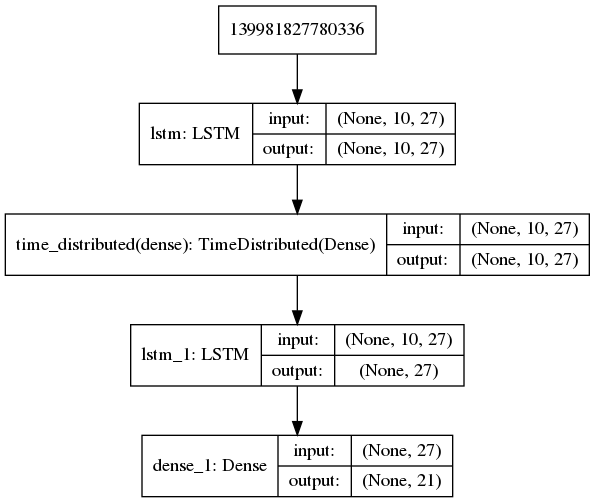

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 215.2461 - mean_absolute_error: 4.2275
Epoch 00001: loss improved from inf to 214.97622, saving model to models/model-6/20190603095033/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 214.8597 - mean_absolute_error: 4.2238
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 102.4702 - mean_absolute_error: 3.3663
Epoch 00002: loss improved from 214.97622 to 102.58311, saving model to models/model-6/20190603095033/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 102.5301 - mean_absolute_error: 3.3702
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 77.3556 - mean_absolute_error: 3.1156
Epoch 00003: loss improved from 102.58311 to 77.28900, saving model to models/model-6/20190603095033/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 77.2500 - mean_absolute_error: 3.1150
Epoch 4/200
1000/10

Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.1214 - mean_absolute_error: 1.4324
Epoch 00027: loss improved from 11.14761 to 11.13488, saving model to models/model-6/20190603095033/epoch27.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 11.1287 - mean_absolute_error: 1.4326
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.7163 - mean_absolute_error: 1.4569
Epoch 00028: loss did not improve from 11.13488
1002/1002 [==============================] - 19s 19ms/step - loss: 11.7358 - mean_absolute_error: 1.4597
Epoch 29/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.4620 - mean_absolute_error: 1.4372
Epoch 00029: loss did not improve from 11.13488
1002/1002 [==============================] - 19s 19ms/step - loss: 11.4546 - mean_absolute_error: 1.4381
Epoch 30/200
1000/1002 [============================>.] - ETA: 0s - loss: 10.8700 - mean_absolute_error: 1.4166
Epoch 00030: loss improved fro

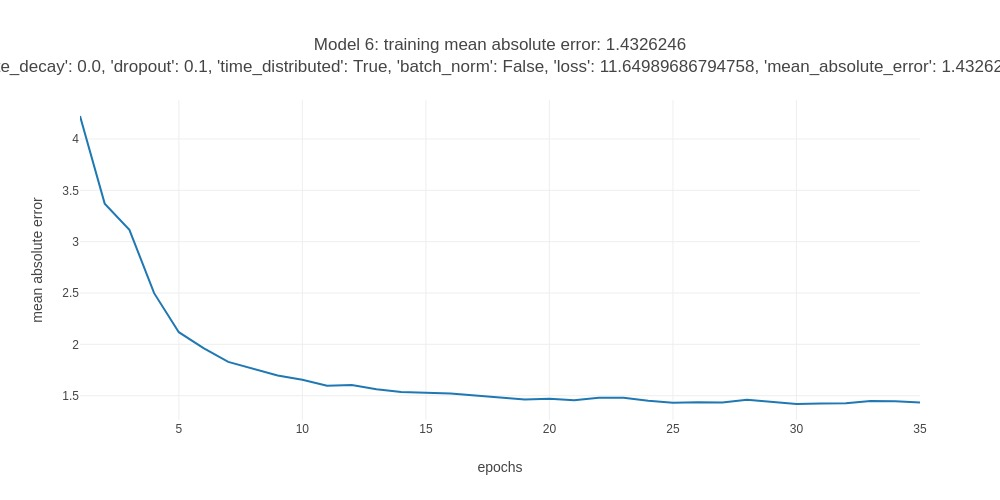

10-01-40 | INFO | models/model-6/20190603100140
INFO:CS230:models/model-6/20190603100140
10-01-40 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 10, 27)            108       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_3 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


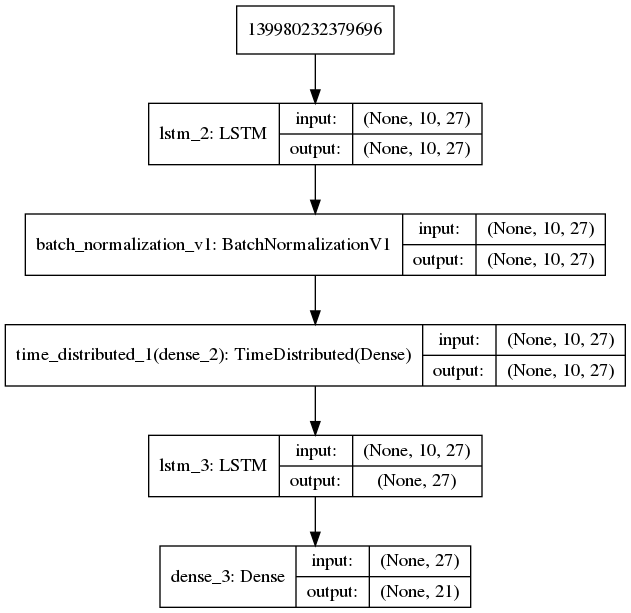

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 328.0697 - mean_absolute_error: 5.3037
Epoch 00001: loss improved from inf to 328.93673, saving model to models/model-6/20190603100140/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 328.7685 - mean_absolute_error: 5.3087
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 326.1561 - mean_absolute_error: 5.3429
Epoch 00002: loss improved from 328.93673 to 327.02187, saving model to models/model-6/20190603100140/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 326.8675 - mean_absolute_error: 5.3454
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.6395 - mean_absolute_error: 5.2621
Epoch 00003: loss did not improve from 327.02187
1002/1002 [==============================] - 19s 19ms/step - loss: 327.0706 - mean_absolute_error: 5.2573
Epoch 4/200
1000/1002 [============================>.] - ETA: 0s - loss: 326.93

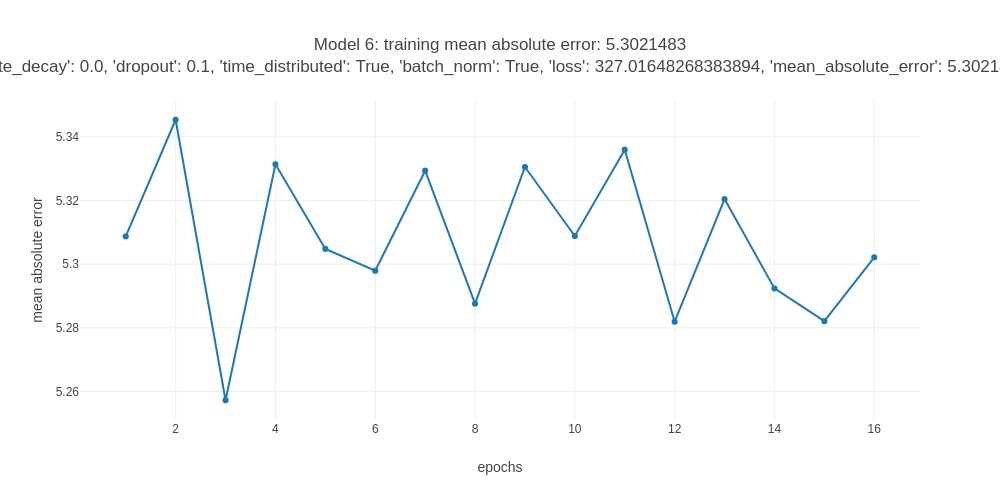

10-06-53 | INFO | models/model-6/20190603100653
INFO:CS230:models/model-6/20190603100653
10-06-53 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 10, 27)            108       
_________________________________________________________________
lstm_5 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dense_4 (Dense)              (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


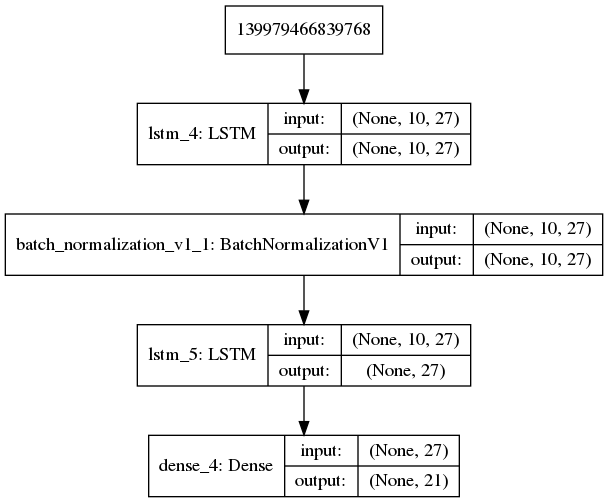

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 247.1761 - mean_absolute_error: 4.5288
Epoch 00001: loss improved from inf to 246.88654, saving model to models/model-6/20190603100653/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 246.7543 - mean_absolute_error: 4.5254
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 104.7196 - mean_absolute_error: 3.4883
Epoch 00002: loss improved from 246.88654 to 104.56786, saving model to models/model-6/20190603100653/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 104.5249 - mean_absolute_error: 3.4841
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 57.7596 - mean_absolute_error: 2.6353
Epoch 00003: loss improved from 104.56786 to 57.71047, saving model to models/model-6/20190603100653/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 57.6806 - mean_absolute_error: 2.6341
Epoch 4/200
1000/10

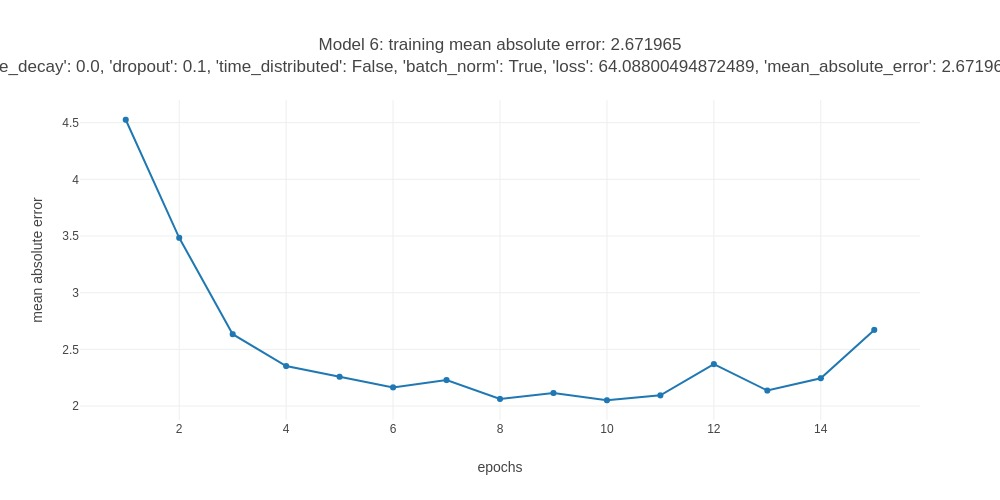

10-11-43 | INFO | models/model-6/20190603101143
INFO:CS230:models/model-6/20190603101143
10-11-43 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_7 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dense_6 (Dense)              (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


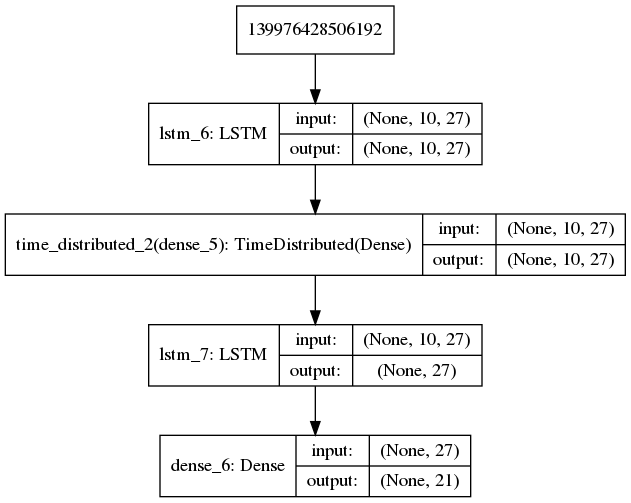

Epoch 1/200
 998/1002 [============================>.] - ETA: 0s - loss: 308.0662 - mean_absolute_error: 4.9264
Epoch 00001: loss improved from inf to 308.21055, saving model to models/model-6/20190603101143/epoch1.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 308.0552 - mean_absolute_error: 4.9284
Epoch 2/200
 999/1002 [============================>.] - ETA: 0s - loss: 175.9369 - mean_absolute_error: 3.9079
Epoch 00002: loss improved from 308.21055 to 176.82543, saving model to models/model-6/20190603101143/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 176.7332 - mean_absolute_error: 3.9145
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 92.6858 - mean_absolute_error: 3.2460
Epoch 00003: loss improved from 176.82543 to 92.49382, saving model to models/model-6/20190603101143/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 92.4453 - mean_absolute_error: 3.2420
Epoch 4/200
 999/10

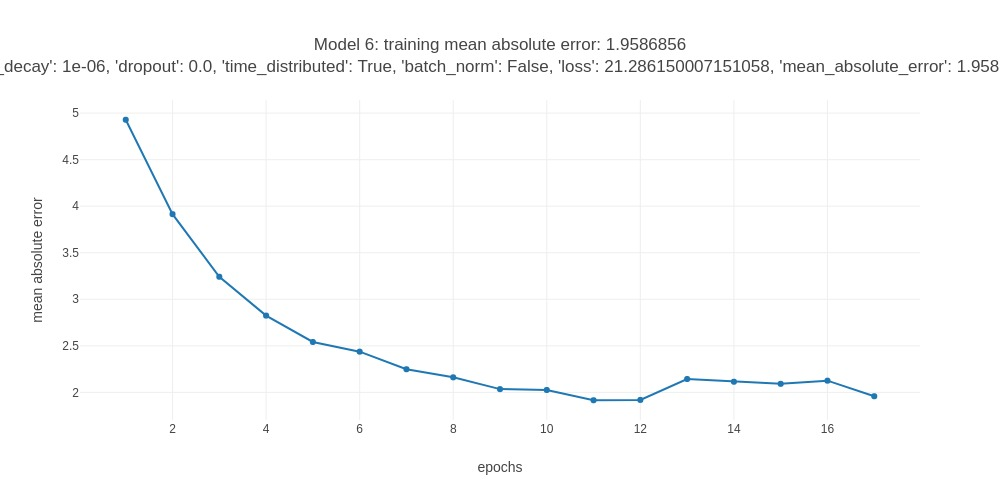

10-16-32 | INFO | models/model-6/20190603101632
INFO:CS230:models/model-6/20190603101632
10-16-32 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 10, 27)            108       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_9 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dense_8 (Dense)              (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


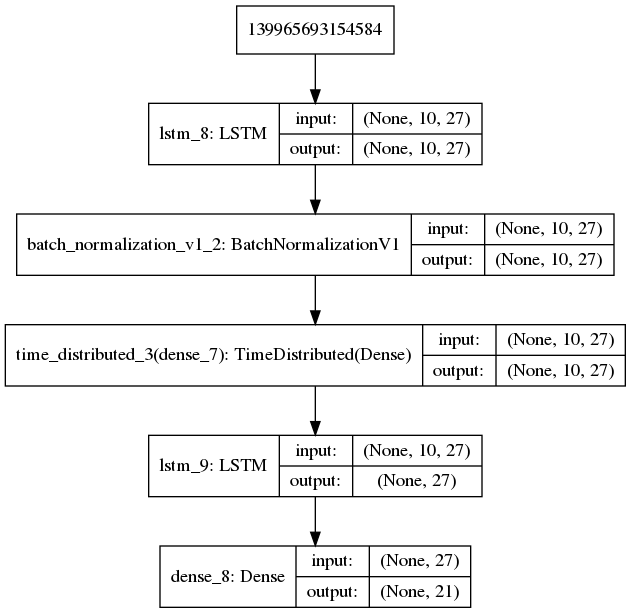

Epoch 1/200
 999/1002 [============================>.] - ETA: 0s - loss: 329.1615 - mean_absolute_error: 5.2744
Epoch 00001: loss improved from inf to 328.91891, saving model to models/model-6/20190603101632/epoch1.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 328.7451 - mean_absolute_error: 5.2738
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 327.2136 - mean_absolute_error: 5.2955
Epoch 00002: loss improved from 328.91891 to 327.09143, saving model to models/model-6/20190603101632/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 326.9303 - mean_absolute_error: 5.2934
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.6469 - mean_absolute_error: 5.2914
Epoch 00003: loss did not improve from 327.09143
1002/1002 [==============================] - 17s 17ms/step - loss: 327.1066 - mean_absolute_error: 5.2877
Epoch 4/200
 999/1002 [============================>.] - ETA: 0s - loss: 328.20

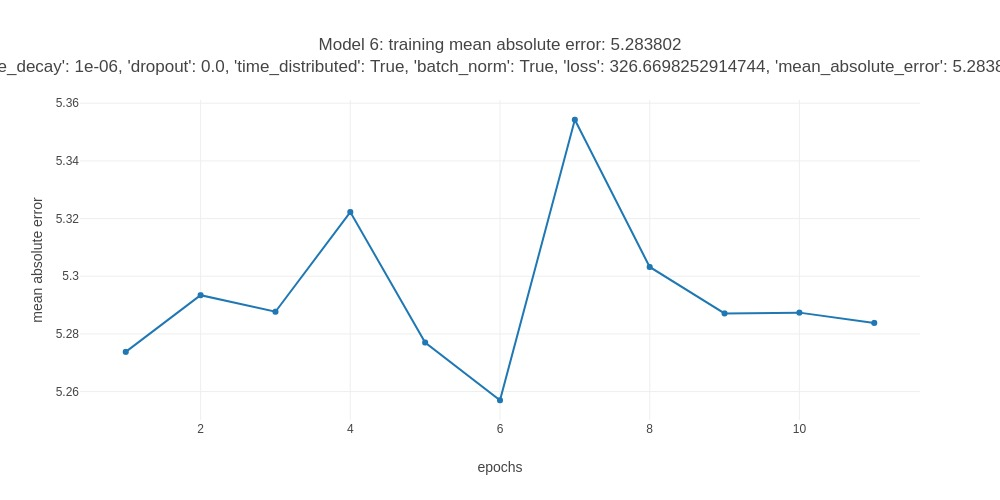

10-19-48 | INFO | models/model-6/20190603101948
INFO:CS230:models/model-6/20190603101948
10-19-48 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_11 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


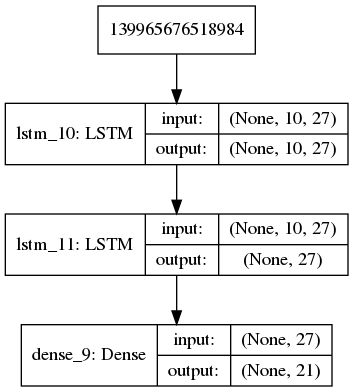

Epoch 1/200
 999/1002 [============================>.] - ETA: 0s - loss: 175.5380 - mean_absolute_error: 4.0518
Epoch 00001: loss improved from inf to 175.40484, saving model to models/model-6/20190603101948/epoch1.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 175.3101 - mean_absolute_error: 4.0528
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 58.0637 - mean_absolute_error: 2.7896
Epoch 00002: loss improved from 175.40484 to 58.03784, saving model to models/model-6/20190603101948/epoch2.h5
1002/1002 [==============================] - 16s 16ms/step - loss: 58.0073 - mean_absolute_error: 2.7873
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 37.4017 - mean_absolute_error: 2.2062
Epoch 00003: loss improved from 58.03784 to 37.37678, saving model to models/model-6/20190603101948/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 37.3564 - mean_absolute_error: 2.2058
Epoch 4/200
1001/1002 [

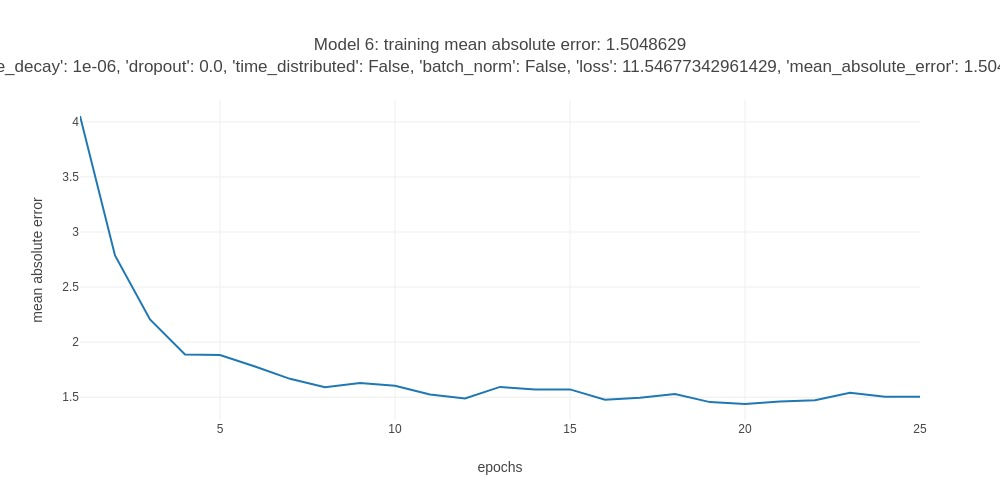

10-26-50 | INFO | models/model-6/20190603102650
INFO:CS230:models/model-6/20190603102650
10-26-50 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 10, 27)            108       
_________________________________________________________________
lstm_13 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_10 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


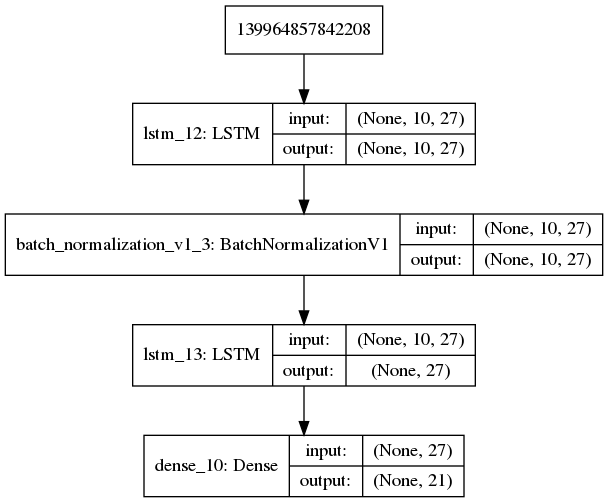

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 205.8862 - mean_absolute_error: 4.3797
Epoch 00001: loss improved from inf to 205.81616, saving model to models/model-6/20190603102650/epoch1.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 205.7052 - mean_absolute_error: 4.3811
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 82.3792 - mean_absolute_error: 3.2818
Epoch 00002: loss improved from 205.81616 to 82.38211, saving model to models/model-6/20190603102650/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 82.3393 - mean_absolute_error: 3.2845
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 59.9235 - mean_absolute_error: 2.8847
Epoch 00003: loss improved from 82.38211 to 59.96324, saving model to models/model-6/20190603102650/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 59.9299 - mean_absolute_error: 2.8852
Epoch 4/200
1000/1002 [

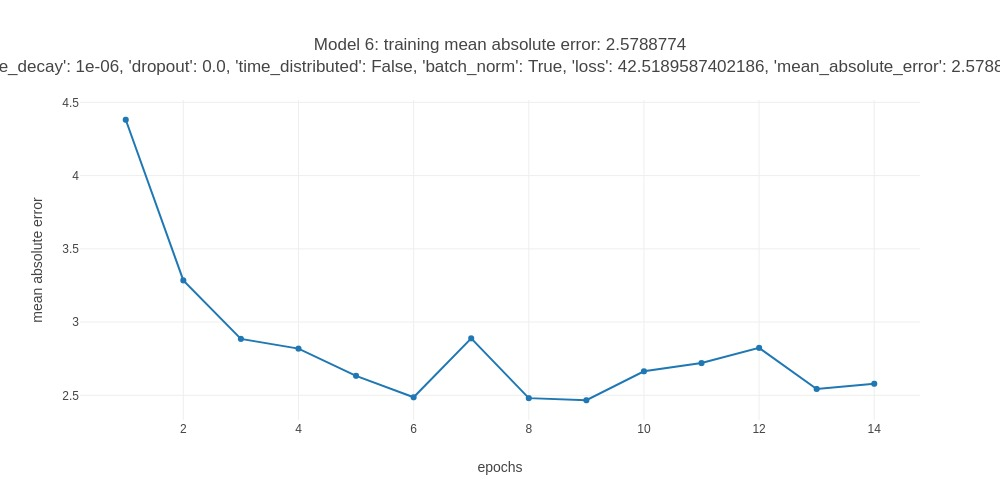

10-30-59 | INFO | models/model-6/20190603103059
INFO:CS230:models/model-6/20190603103059
10-30-59 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_15 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_12 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


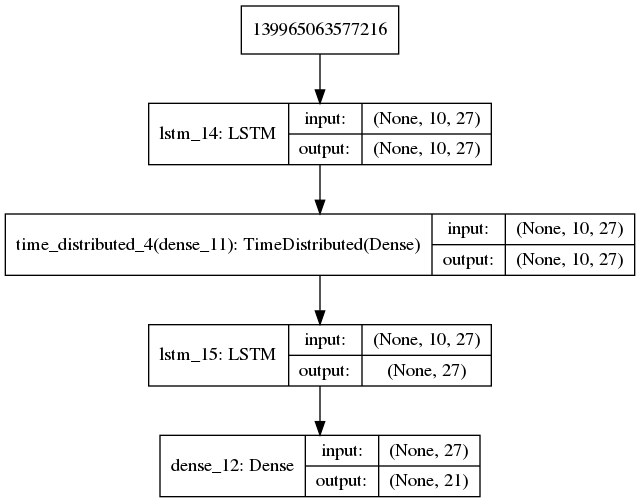

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 329.3565 - mean_absolute_error: 5.2427
Epoch 00001: loss improved from inf to 328.92092, saving model to models/model-6/20190603103059/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 328.7686 - mean_absolute_error: 5.2374
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 313.4308 - mean_absolute_error: 5.1314
Epoch 00002: loss improved from 328.92092 to 313.45727, saving model to models/model-6/20190603103059/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 313.3010 - mean_absolute_error: 5.1309
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 268.9547 - mean_absolute_error: 4.6726
Epoch 00003: loss improved from 313.45727 to 268.61579, saving model to models/model-6/20190603103059/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 268.4770 - mean_absolute_error: 4.6683
Epoch 4/200
1000

Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 12.0490 - mean_absolute_error: 1.4982
Epoch 00027: loss improved from 12.11331 to 12.05475, saving model to models/model-6/20190603103059/epoch27.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 12.0481 - mean_absolute_error: 1.4989
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.8599 - mean_absolute_error: 1.4939
Epoch 00028: loss improved from 12.05475 to 11.85136, saving model to models/model-6/20190603103059/epoch28.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 11.8449 - mean_absolute_error: 1.4932
Epoch 29/200
1001/1002 [============================>.] - ETA: 0s - loss: 17.0642 - mean_absolute_error: 1.6998
Epoch 00029: loss did not improve from 11.85136
1002/1002 [==============================] - 19s 19ms/step - loss: 17.0474 - mean_absolute_error: 1.6984
Epoch 30/200
1000/1002 [============================>.] - ETA: 0s - loss: 15.10

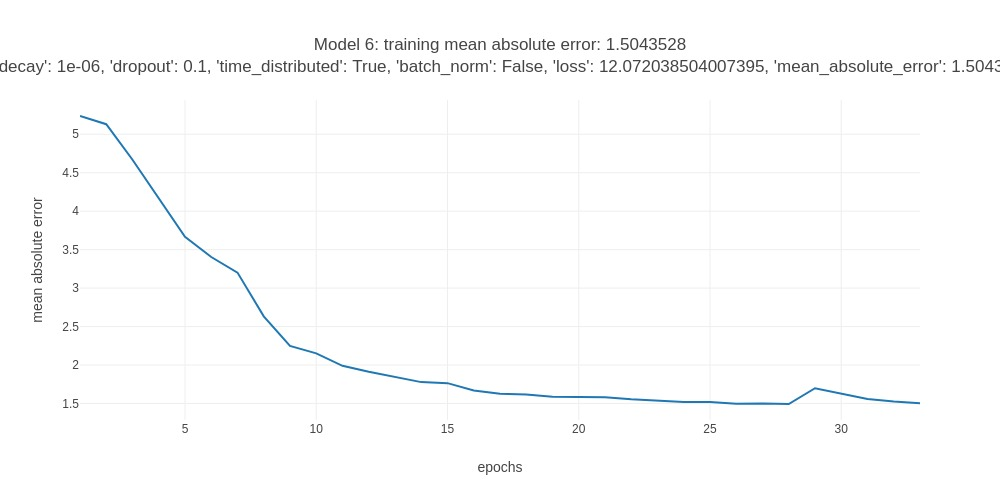

10-41-32 | INFO | models/model-6/20190603104132
INFO:CS230:models/model-6/20190603104132
10-41-32 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 10, 27)            108       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_17 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_14 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


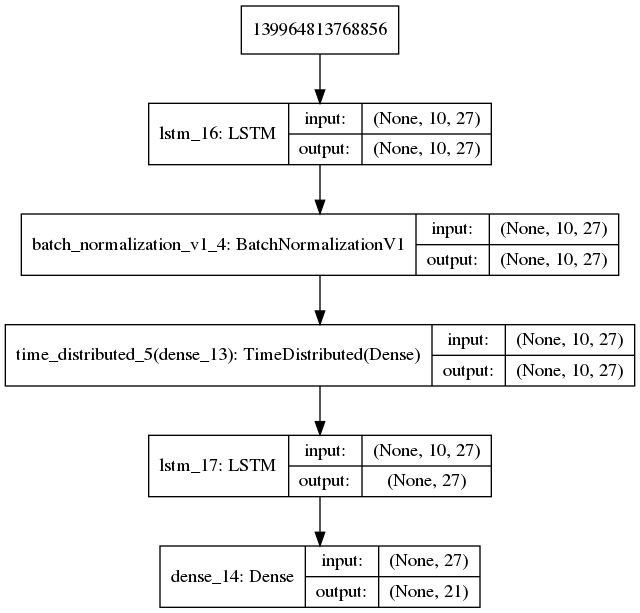

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 328.2514 - mean_absolute_error: 5.3012
Epoch 00001: loss improved from inf to 329.28709, saving model to models/model-6/20190603104132/epoch1.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 329.1239 - mean_absolute_error: 5.3064
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 325.7705 - mean_absolute_error: 5.2666
Epoch 00002: loss improved from 329.28709 to 325.41828, saving model to models/model-6/20190603104132/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 325.2641 - mean_absolute_error: 5.2646
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.7153 - mean_absolute_error: 5.3455
Epoch 00003: loss did not improve from 325.41828
1002/1002 [==============================] - 19s 19ms/step - loss: 327.2305 - mean_absolute_error: 5.3420
Epoch 4/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.89

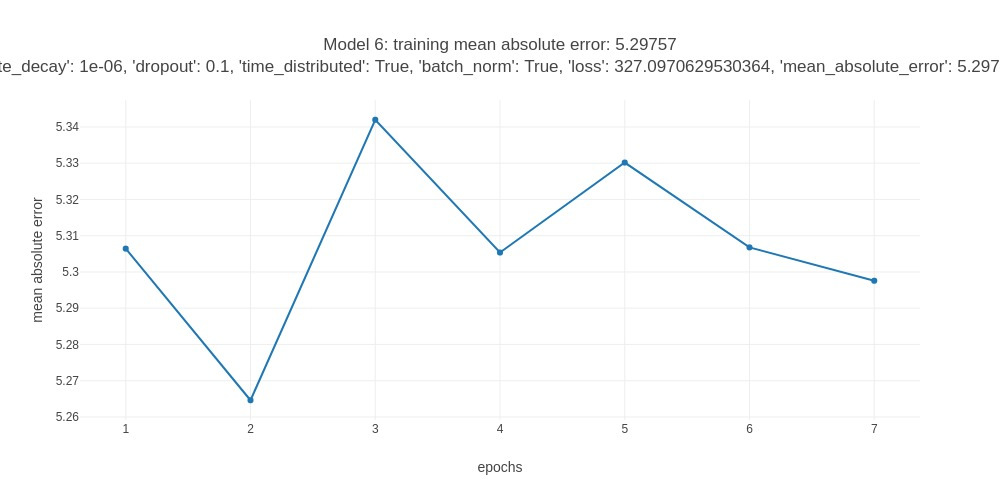

10-43-55 | INFO | models/model-6/20190603104355
INFO:CS230:models/model-6/20190603104355
10-43-55 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_19 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_15 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


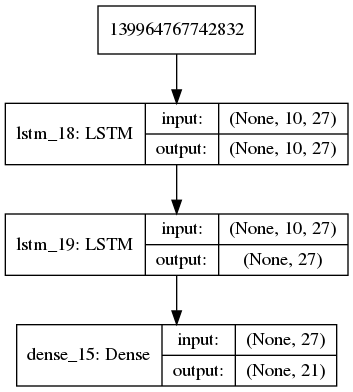

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 170.5405 - mean_absolute_error: 3.6206
Epoch 00001: loss improved from inf to 170.51349, saving model to models/model-6/20190603104355/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 170.4184 - mean_absolute_error: 3.6224
Epoch 2/200
 999/1002 [============================>.] - ETA: 0s - loss: 46.0456 - mean_absolute_error: 2.3700
Epoch 00002: loss improved from 170.51349 to 46.04785, saving model to models/model-6/20190603104355/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 46.0230 - mean_absolute_error: 2.3705
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 28.5316 - mean_absolute_error: 1.9951
Epoch 00003: loss improved from 46.04785 to 28.50694, saving model to models/model-6/20190603104355/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 28.4911 - mean_absolute_error: 1.9959
Epoch 4/200
 999/1002 [

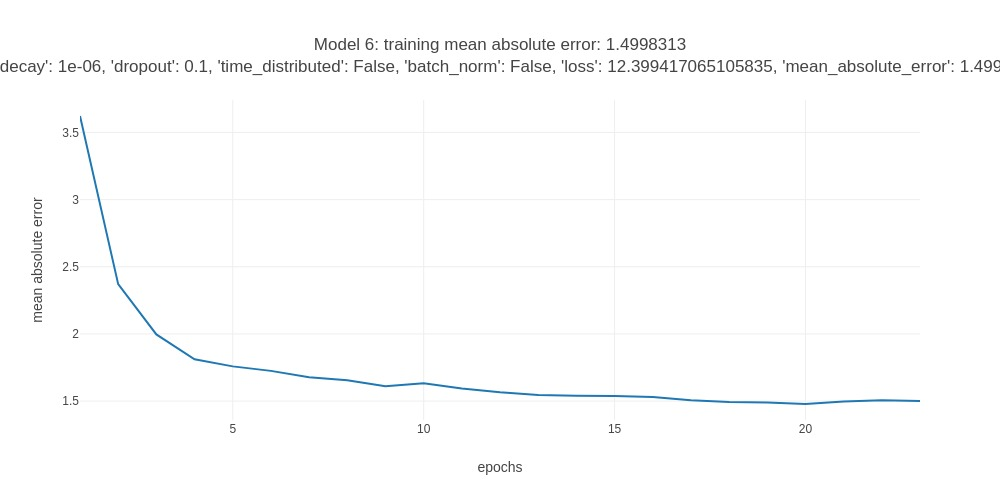

10-51-17 | INFO | models/model-6/20190603105117
INFO:CS230:models/model-6/20190603105117
10-51-17 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.02, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 10, 27)            108       
_________________________________________________________________
lstm_21 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_16 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


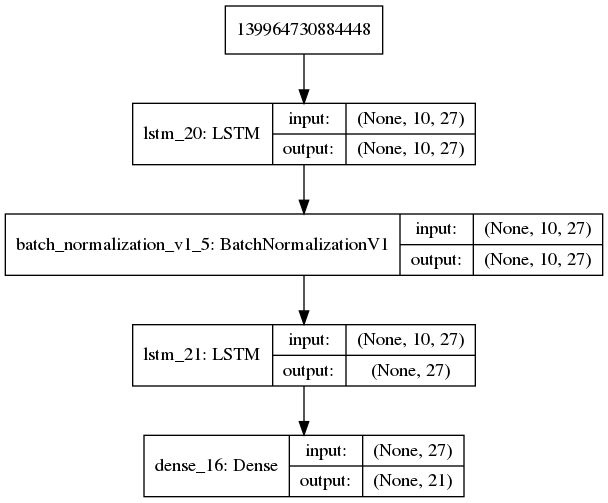

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 227.2442 - mean_absolute_error: 4.2393
Epoch 00001: loss improved from inf to 227.09444, saving model to models/model-6/20190603105117/epoch1.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 226.9705 - mean_absolute_error: 4.2402
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 77.6547 - mean_absolute_error: 2.7981
Epoch 00002: loss improved from 227.09444 to 77.64224, saving model to models/model-6/20190603105117/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 77.5990 - mean_absolute_error: 2.8002
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 53.9805 - mean_absolute_error: 2.6444
Epoch 00003: loss improved from 77.64224 to 53.91714, saving model to models/model-6/20190603105117/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 53.8909 - mean_absolute_error: 2.6425
Epoch 4/200
1000/1002 [

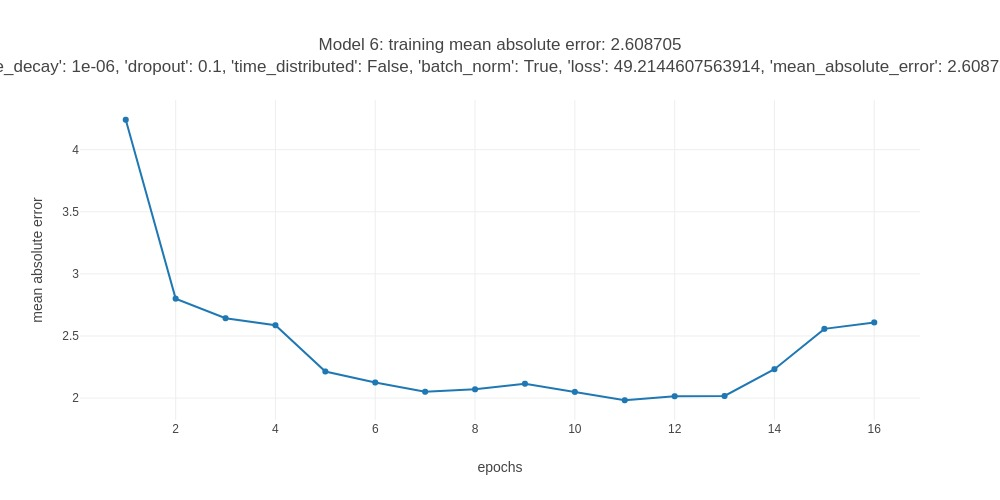

10-56-35 | INFO | models/model-6/20190603105635
INFO:CS230:models/model-6/20190603105635
10-56-35 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_23 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_18 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


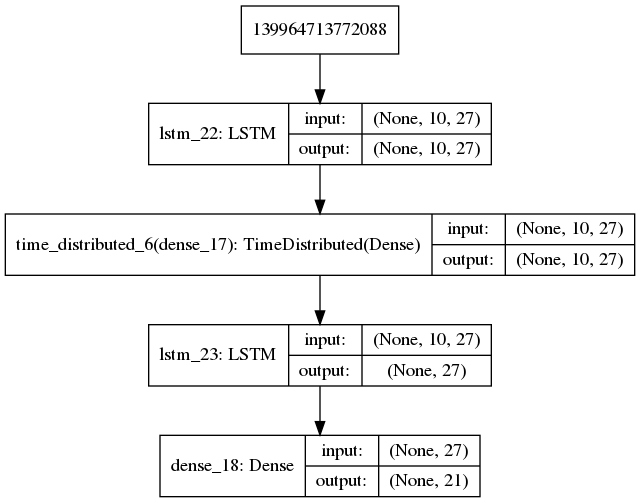

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 273.1286 - mean_absolute_error: 4.5979
Epoch 00001: loss improved from inf to 272.82422, saving model to models/model-6/20190603105635/epoch1.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 272.6804 - mean_absolute_error: 4.5955
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 143.7966 - mean_absolute_error: 3.7251
Epoch 00002: loss improved from 272.82422 to 143.73801, saving model to models/model-6/20190603105635/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 143.6625 - mean_absolute_error: 3.7227
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 88.5490 - mean_absolute_error: 3.0905
Epoch 00003: loss improved from 143.73801 to 88.68717, saving model to models/model-6/20190603105635/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 88.6385 - mean_absolute_error: 3.0947
Epoch 4/200
1001/10

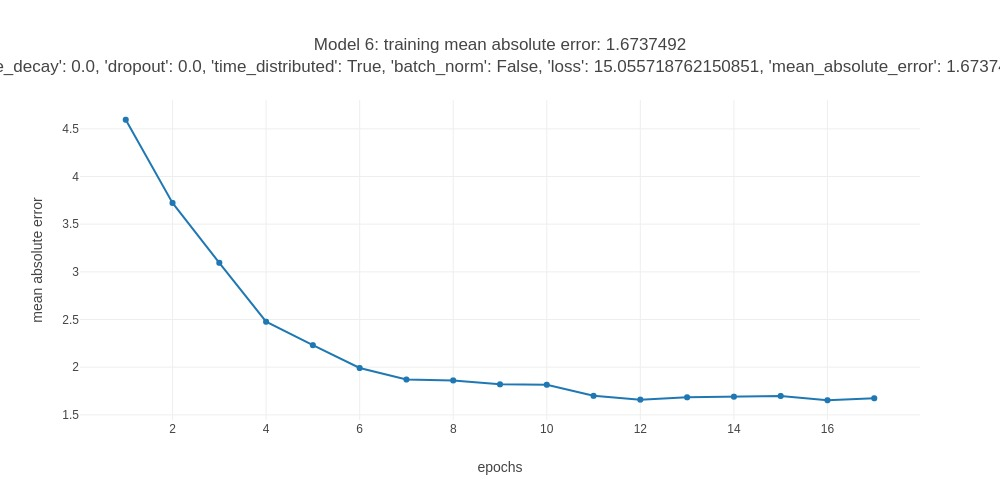

11-01-35 | INFO | models/model-6/20190603110134
INFO:CS230:models/model-6/20190603110134
11-01-35 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 10, 27)            108       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_25 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_20 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


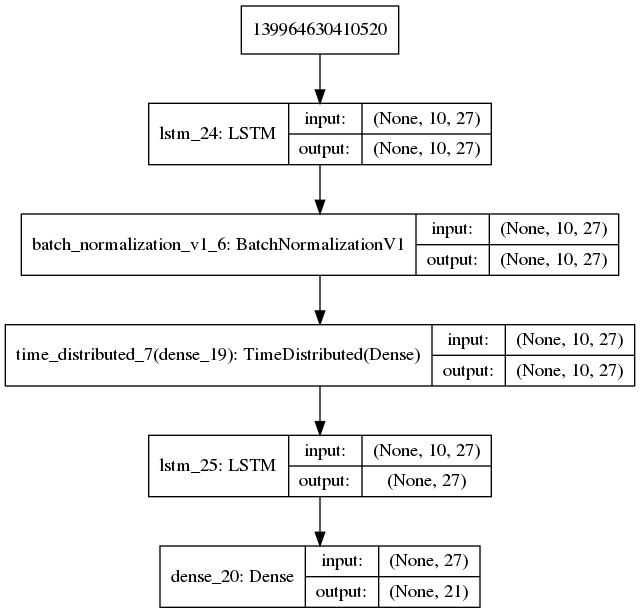

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 325.5577 - mean_absolute_error: 5.1263
Epoch 00001: loss improved from inf to 325.24879, saving model to models/model-6/20190603110134/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 325.0890 - mean_absolute_error: 5.1254
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 296.1156 - mean_absolute_error: 4.8270
Epoch 00002: loss improved from 325.24879 to 295.78091, saving model to models/model-6/20190603110134/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 295.6189 - mean_absolute_error: 4.8239
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 244.9325 - mean_absolute_error: 4.3075
Epoch 00003: loss improved from 295.78091 to 244.35767, saving model to models/model-6/20190603110134/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 244.2318 - mean_absolute_error: 4.2988
Epoch 4/200
1000

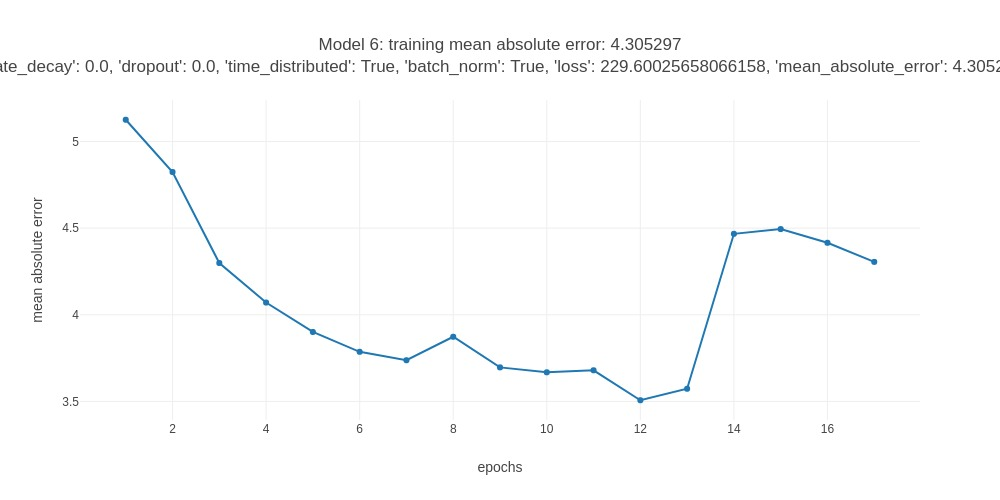

11-06-45 | INFO | models/model-6/20190603110645
INFO:CS230:models/model-6/20190603110645
11-06-45 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_27 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_21 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


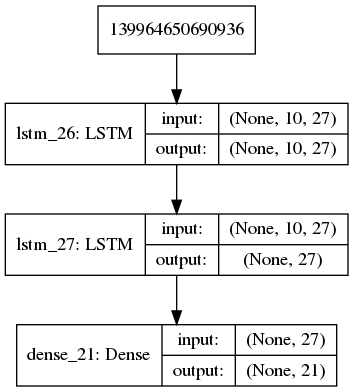

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 192.5245 - mean_absolute_error: 3.9992
Epoch 00001: loss improved from inf to 192.25647, saving model to models/model-6/20190603110645/epoch1.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 192.1521 - mean_absolute_error: 3.9935
Epoch 2/200
 999/1002 [============================>.] - ETA: 0s - loss: 67.9186 - mean_absolute_error: 2.6573
Epoch 00002: loss improved from 192.25647 to 67.85080, saving model to models/model-6/20190603110645/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 67.8130 - mean_absolute_error: 2.6577
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 36.1645 - mean_absolute_error: 2.1597
Epoch 00003: loss improved from 67.85080 to 36.18833, saving model to models/model-6/20190603110645/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 36.1682 - mean_absolute_error: 2.1599
Epoch 4/200
 999/1002 [

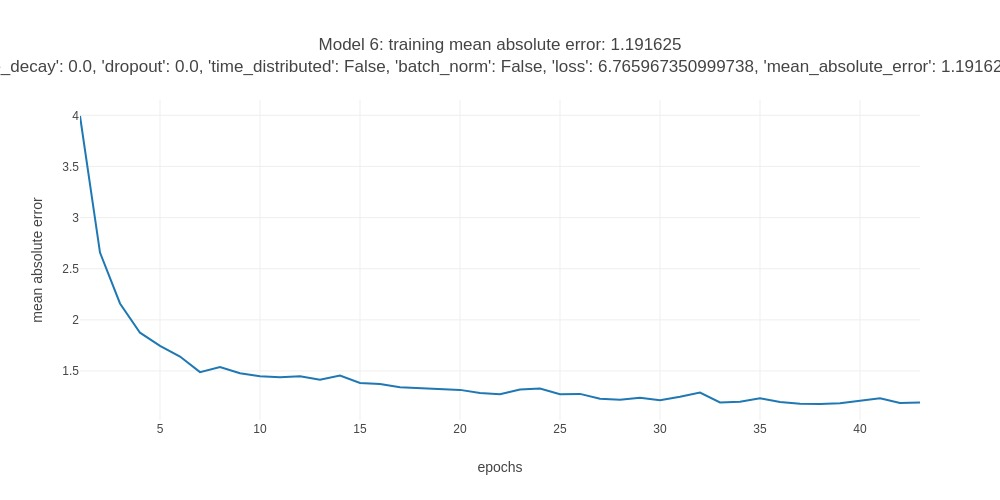

11-19-01 | INFO | models/model-6/20190603111901
INFO:CS230:models/model-6/20190603111901
11-19-01 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 10, 27)            108       
_________________________________________________________________
lstm_29 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_22 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


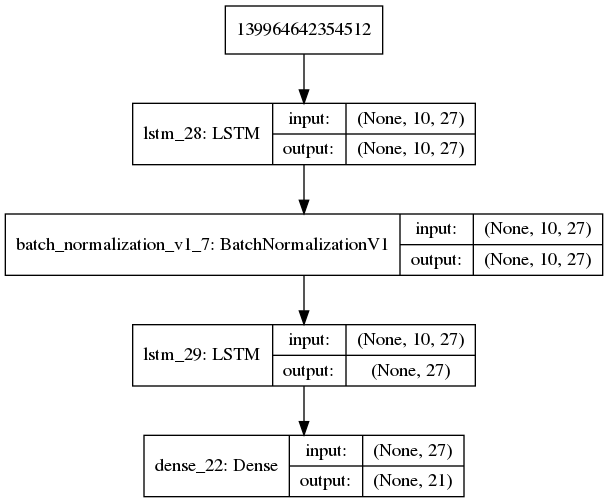

Epoch 1/200
1001/1002 [============================>.] - ETA: 0s - loss: 308.5625 - mean_absolute_error: 4.9304
Epoch 00001: loss improved from inf to 308.41048, saving model to models/model-6/20190603111901/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 308.2566 - mean_absolute_error: 4.9264
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 177.8320 - mean_absolute_error: 3.9601
Epoch 00002: loss improved from 308.41048 to 177.75820, saving model to models/model-6/20190603111901/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 177.6668 - mean_absolute_error: 3.9583
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 101.5706 - mean_absolute_error: 3.3836
Epoch 00003: loss improved from 177.75820 to 101.47640, saving model to models/model-6/20190603111901/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 101.4236 - mean_absolute_error: 3.3823
Epoch 4/200
1000

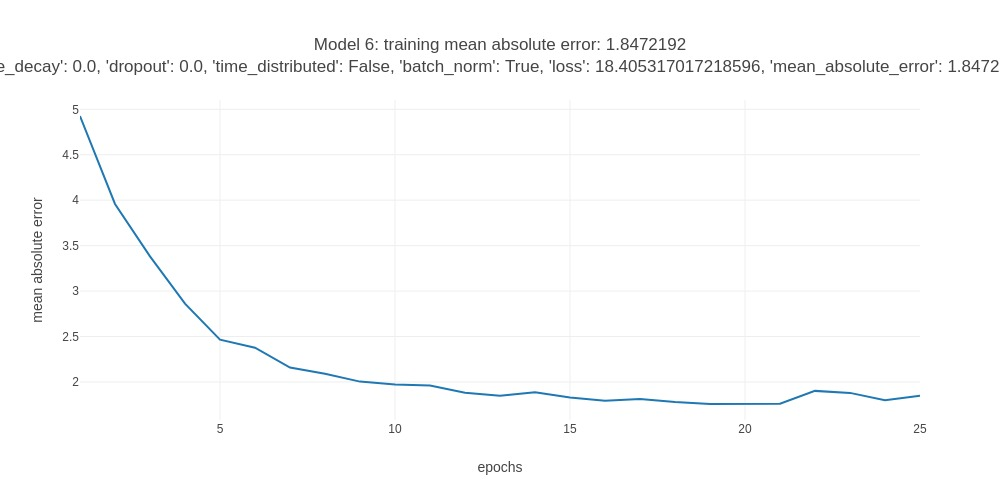

11-26-29 | INFO | models/model-6/20190603112629
INFO:CS230:models/model-6/20190603112629
11-26-29 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_31 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_24 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


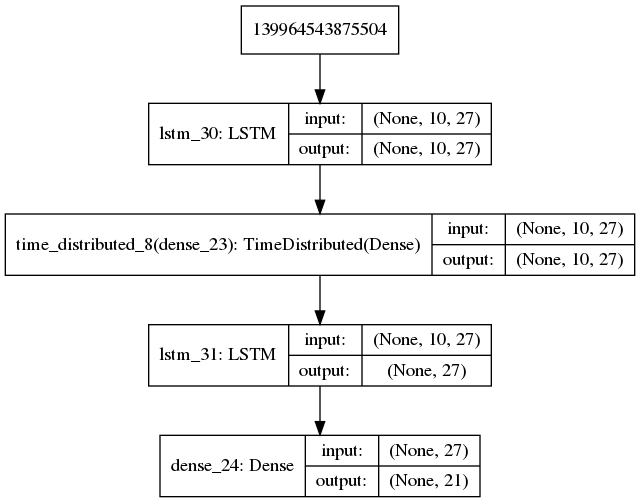

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 259.3770 - mean_absolute_error: 4.4055
Epoch 00001: loss improved from inf to 259.52372, saving model to models/model-6/20190603112629/epoch1.h5
1002/1002 [==============================] - 22s 22ms/step - loss: 259.3847 - mean_absolute_error: 4.4084
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 126.2457 - mean_absolute_error: 3.6149
Epoch 00002: loss improved from 259.52372 to 127.14748, saving model to models/model-6/20190603112629/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 127.0803 - mean_absolute_error: 3.6202
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 83.5908 - mean_absolute_error: 3.2647
Epoch 00003: loss improved from 127.14748 to 83.50393, saving model to models/model-6/20190603112629/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 83.4645 - mean_absolute_error: 3.2623
Epoch 4/200
1000/10

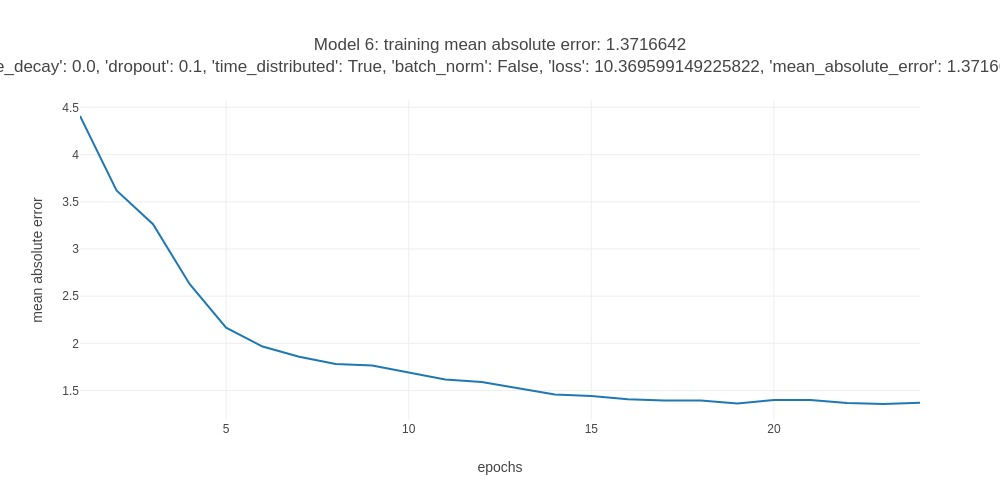

11-34-22 | INFO | models/model-6/20190603113422
INFO:CS230:models/model-6/20190603113422
11-34-22 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 10, 27)            108       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 27)            756       
_________________________________________________________________
lstm_33 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_26 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


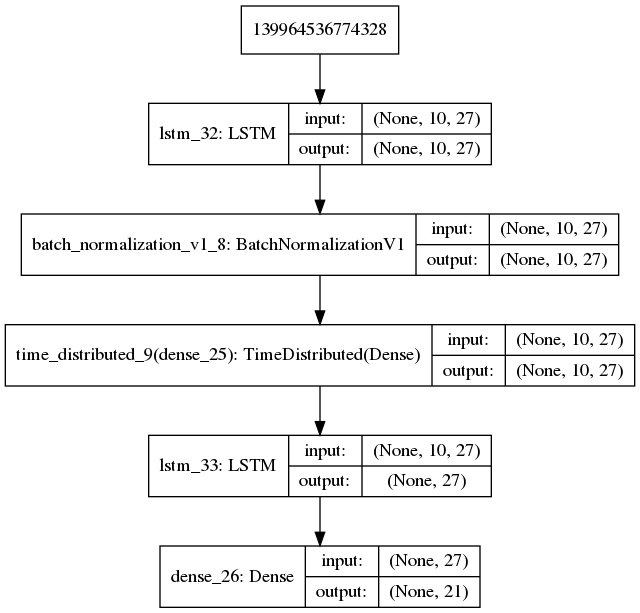

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 329.9232 - mean_absolute_error: 5.2760
Epoch 00001: loss improved from inf to 329.51928, saving model to models/model-6/20190603113422/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 329.3523 - mean_absolute_error: 5.2714
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 326.1520 - mean_absolute_error: 5.2728
Epoch 00002: loss improved from 329.51928 to 326.89899, saving model to models/model-6/20190603113422/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 326.7437 - mean_absolute_error: 5.2755
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 326.4785 - mean_absolute_error: 5.2942
Epoch 00003: loss improved from 326.89899 to 326.80712, saving model to models/model-6/20190603113422/epoch3.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 326.6510 - mean_absolute_error: 5.2947
Epoch 4/200
1000

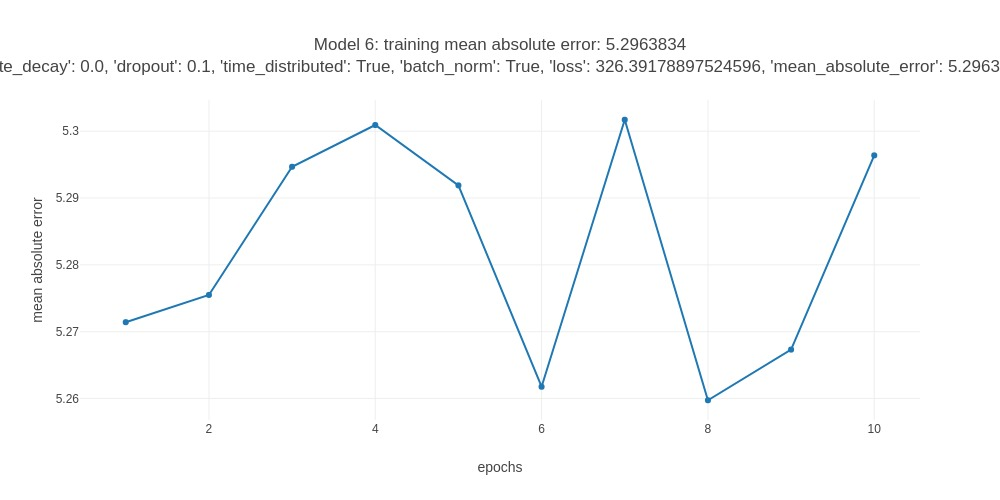

11-37-50 | INFO | models/model-6/20190603113750
INFO:CS230:models/model-6/20190603113750
11-37-50 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_35 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_27 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


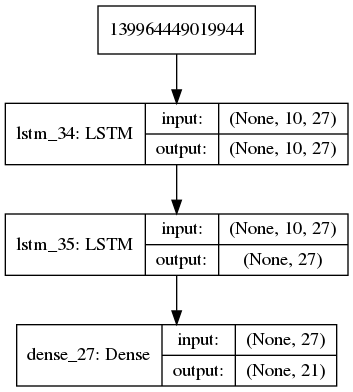

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 190.4940 - mean_absolute_error: 3.8969
Epoch 00001: loss improved from inf to 190.66751, saving model to models/model-6/20190603113750/epoch1.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 190.5617 - mean_absolute_error: 3.9025
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 54.6262 - mean_absolute_error: 2.4911
Epoch 00002: loss improved from 190.66751 to 54.88543, saving model to models/model-6/20190603113750/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 54.8549 - mean_absolute_error: 2.4932
Epoch 3/200
1001/1002 [============================>.] - ETA: 0s - loss: 27.3050 - mean_absolute_error: 1.9818
Epoch 00003: loss improved from 54.88543 to 27.29314, saving model to models/model-6/20190603113750/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 27.2780 - mean_absolute_error: 1.9801
Epoch 4/200
 999/1002 [

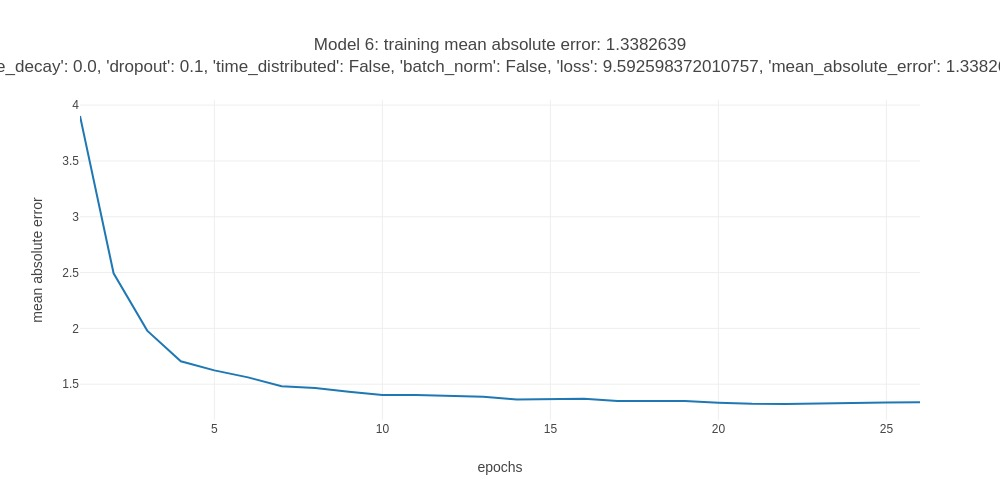

11-46-19 | INFO | models/model-6/20190603114619
INFO:CS230:models/model-6/20190603114619
11-46-19 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 10, 27)            108       
_________________________________________________________________
lstm_37 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_28 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


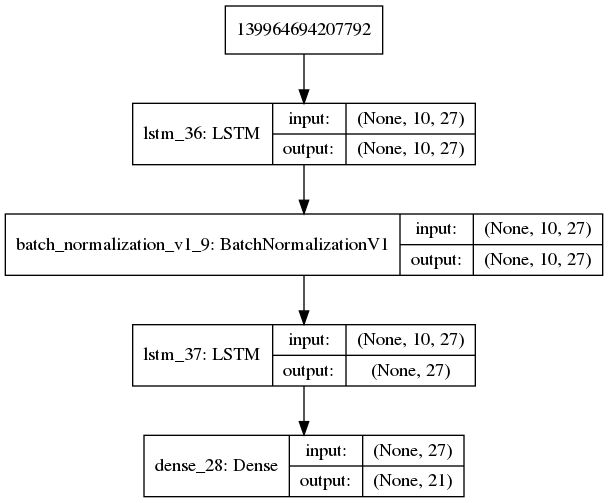

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 263.0010 - mean_absolute_error: 4.4586
Epoch 00001: loss improved from inf to 262.68023, saving model to models/model-6/20190603114619/epoch1.h5
1002/1002 [==============================] - 23s 22ms/step - loss: 262.5346 - mean_absolute_error: 4.4554
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 108.3235 - mean_absolute_error: 3.1635
Epoch 00002: loss improved from 262.68023 to 108.18555, saving model to models/model-6/20190603114619/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 108.1259 - mean_absolute_error: 3.1603
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 60.7677 - mean_absolute_error: 2.5781
Epoch 00003: loss improved from 108.18555 to 60.75924, saving model to models/model-6/20190603114619/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 60.7265 - mean_absolute_error: 2.5800
Epoch 4/200
1001/10

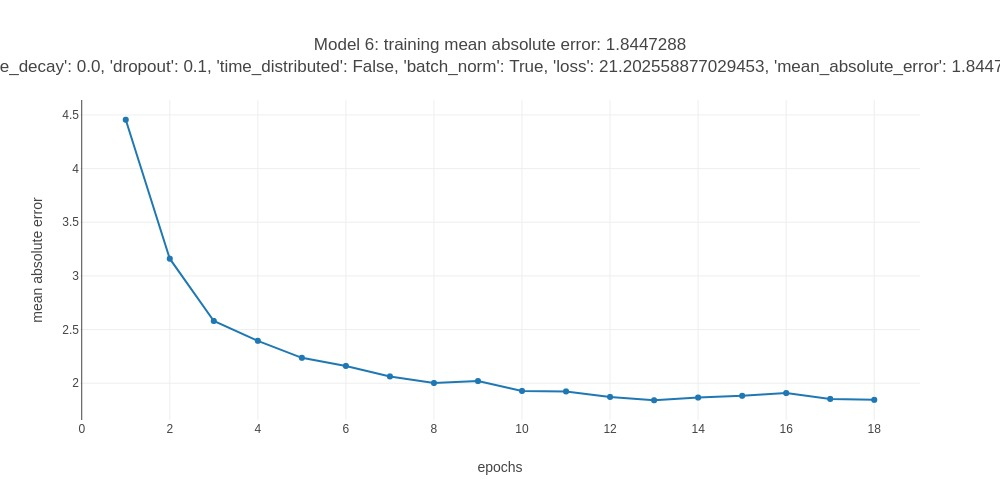

11-52-25 | INFO | models/model-6/20190603115225
INFO:CS230:models/model-6/20190603115225
11-52-25 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_39 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_30 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


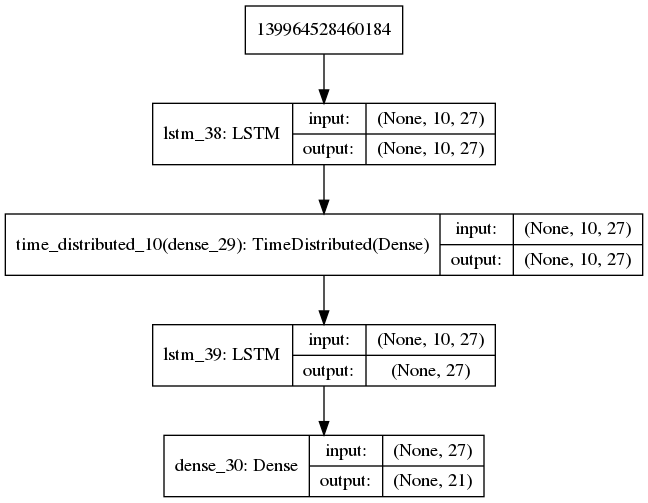

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 263.5547 - mean_absolute_error: 4.4111
Epoch 00001: loss improved from inf to 263.26058, saving model to models/model-6/20190603115225/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 263.1240 - mean_absolute_error: 4.4089
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 137.2806 - mean_absolute_error: 3.6691
Epoch 00002: loss improved from 263.26058 to 137.87472, saving model to models/model-6/20190603115225/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 137.8016 - mean_absolute_error: 3.6733
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 84.9280 - mean_absolute_error: 3.2233
Epoch 00003: loss improved from 137.87472 to 84.84728, saving model to models/model-6/20190603115225/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 84.8028 - mean_absolute_error: 3.2239
Epoch 4/200
 999/10

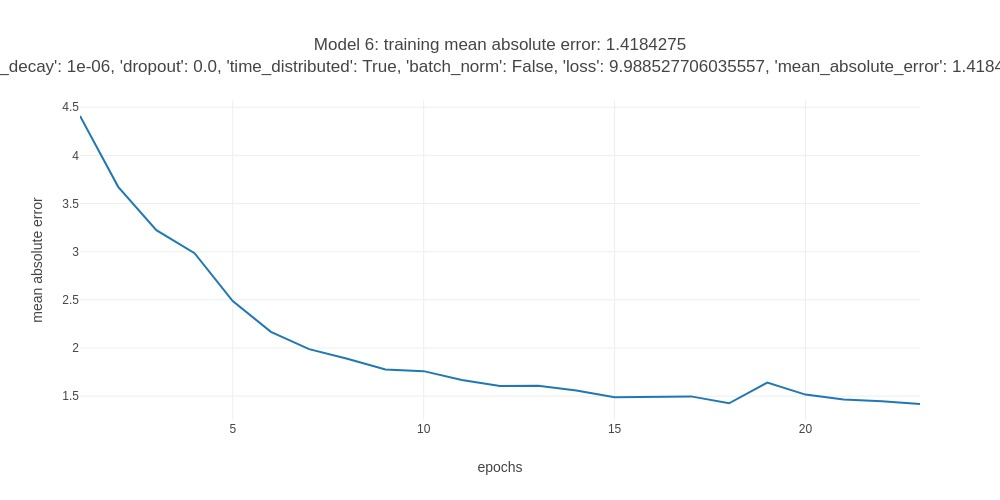

11-59-20 | INFO | models/model-6/20190603115920
INFO:CS230:models/model-6/20190603115920
11-59-20 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 10, 27)            108       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_41 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_32 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


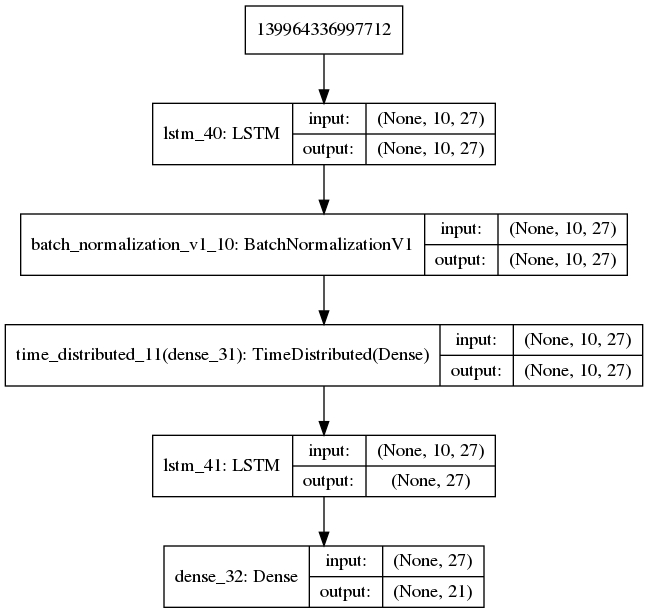

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.3831 - mean_absolute_error: 5.1591
Epoch 00001: loss improved from inf to 327.05549, saving model to models/model-6/20190603115920/epoch1.h5
1002/1002 [==============================] - 22s 21ms/step - loss: 326.8929 - mean_absolute_error: 5.1575
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 315.8531 - mean_absolute_error: 5.0957
Epoch 00002: loss improved from 327.05549 to 315.45832, saving model to models/model-6/20190603115920/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 315.3100 - mean_absolute_error: 5.0909
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 308.9238 - mean_absolute_error: 5.0299
Epoch 00003: loss improved from 315.45832 to 308.53966, saving model to models/model-6/20190603115920/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 308.3900 - mean_absolute_error: 5.0265
Epoch 4/200
1000

1002/1002 [==============================] - 18s 18ms/step - loss: 21.3374 - mean_absolute_error: 1.9370
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 22.8150 - mean_absolute_error: 1.9977
Epoch 00027: loss did not improve from 21.34928
1002/1002 [==============================] - 18s 18ms/step - loss: 22.8369 - mean_absolute_error: 2.0000
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 23.6141 - mean_absolute_error: 2.0455
Epoch 00028: loss did not improve from 21.34928
1002/1002 [==============================] - 18s 18ms/step - loss: 23.5723 - mean_absolute_error: 2.0434
Epoch 29/200
 999/1002 [============================>.] - ETA: 0s - loss: 20.8415 - mean_absolute_error: 1.9434
Epoch 00029: loss improved from 21.34928 to 20.88652, saving model to models/model-6/20190603115920/epoch29.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 20.8752 - mean_absolute_error: 1.9460
Epoch 30/200
1001/1002 [=============

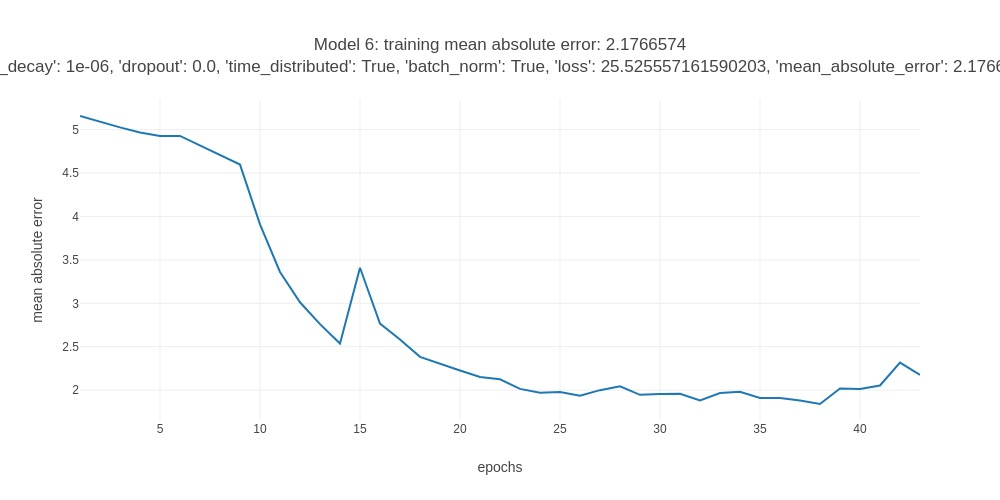

12-12-24 | INFO | models/model-6/20190603121224
INFO:CS230:models/model-6/20190603121224
12-12-24 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_43 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_33 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


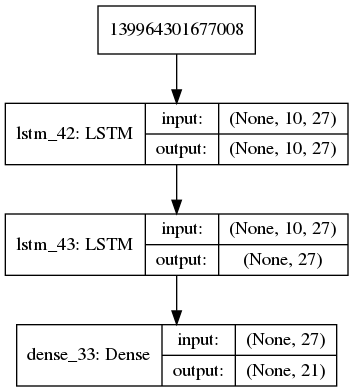

Epoch 1/200
 999/1002 [============================>.] - ETA: 0s - loss: 227.6167 - mean_absolute_error: 4.2946
Epoch 00001: loss improved from inf to 227.10041, saving model to models/model-6/20190603121224/epoch1.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 226.9750 - mean_absolute_error: 4.2870
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 86.5329 - mean_absolute_error: 2.8650
Epoch 00002: loss improved from 227.10041 to 86.43740, saving model to models/model-6/20190603121224/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 86.3893 - mean_absolute_error: 2.8625
Epoch 3/200
1001/1002 [============================>.] - ETA: 0s - loss: 39.2498 - mean_absolute_error: 2.1799
Epoch 00003: loss improved from 86.43740 to 39.24306, saving model to models/model-6/20190603121224/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 39.2211 - mean_absolute_error: 2.1799
Epoch 4/200
 999/1002 [

Epoch 28/200
 998/1002 [============================>.] - ETA: 0s - loss: 6.8462 - mean_absolute_error: 1.1774
Epoch 00028: loss improved from 6.90341 to 6.83196, saving model to models/model-6/20190603121224/epoch28.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 6.8282 - mean_absolute_error: 1.1752
Epoch 29/200
 999/1002 [============================>.] - ETA: 0s - loss: 7.4492 - mean_absolute_error: 1.2095
Epoch 00029: loss did not improve from 6.83196
1002/1002 [==============================] - 17s 17ms/step - loss: 7.4499 - mean_absolute_error: 1.2112
Epoch 30/200
1001/1002 [============================>.] - ETA: 0s - loss: 7.1200 - mean_absolute_error: 1.1870
Epoch 00030: loss did not improve from 6.83196
1002/1002 [==============================] - 17s 17ms/step - loss: 7.1275 - mean_absolute_error: 1.1880
Epoch 31/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.8799 - mean_absolute_error: 1.1785
Epoch 00031: loss did not improve from 6.

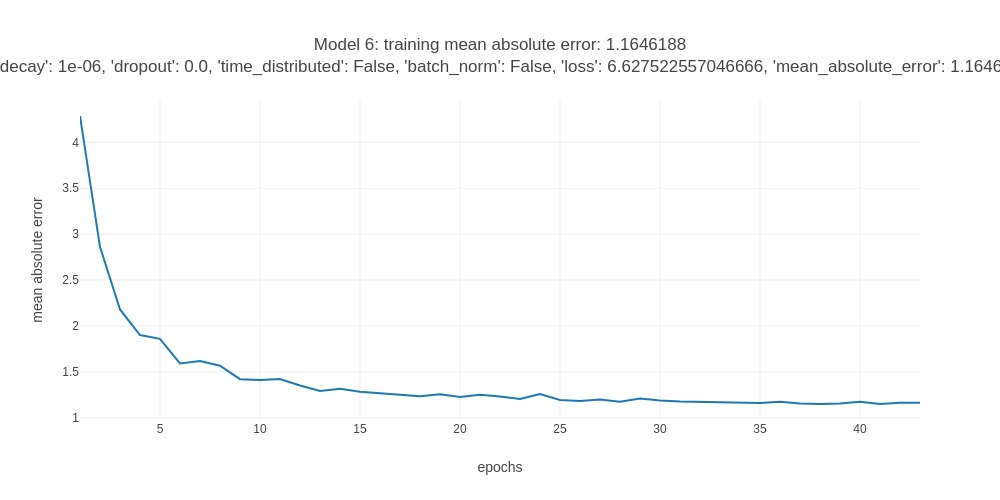

12-25-04 | INFO | models/model-6/20190603122504
INFO:CS230:models/model-6/20190603122504
12-25-04 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_11 (B (None, 10, 27)            108       
_________________________________________________________________
lstm_45 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_34 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


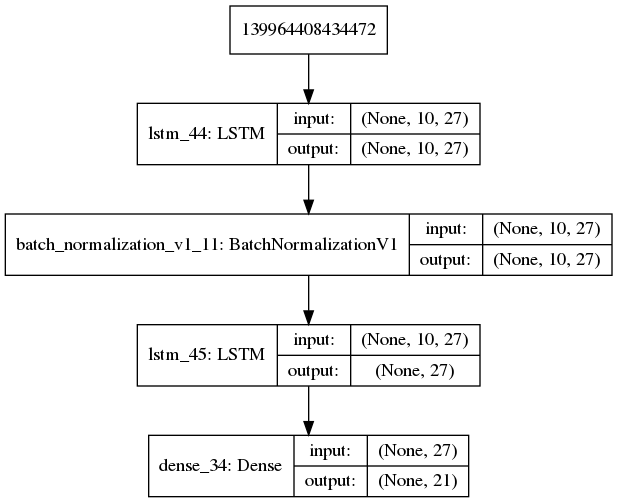

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 258.7578 - mean_absolute_error: 4.5454
Epoch 00001: loss improved from inf to 258.39353, saving model to models/model-6/20190603122504/epoch1.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 258.2609 - mean_absolute_error: 4.5397
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 116.9702 - mean_absolute_error: 3.5806
Epoch 00002: loss improved from 258.39353 to 116.95509, saving model to models/model-6/20190603122504/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 116.8957 - mean_absolute_error: 3.5793
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 59.6178 - mean_absolute_error: 2.7471
Epoch 00003: loss improved from 116.95509 to 59.63743, saving model to models/model-6/20190603122504/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 59.6048 - mean_absolute_error: 2.7494
Epoch 4/200
1001/10

Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 11.6257 - mean_absolute_error: 1.5185
Epoch 00028: loss improved from 12.29577 to 11.60576, saving model to models/model-6/20190603122504/epoch28.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 11.5998 - mean_absolute_error: 1.5166
Epoch 29/200
 999/1002 [============================>.] - ETA: 0s - loss: 12.2420 - mean_absolute_error: 1.5409
Epoch 00029: loss did not improve from 11.60576
1002/1002 [==============================] - 18s 18ms/step - loss: 12.2228 - mean_absolute_error: 1.5406
Epoch 30/200
1000/1002 [============================>.] - ETA: 0s - loss: 10.3299 - mean_absolute_error: 1.4650
Epoch 00030: loss improved from 11.60576 to 10.33670, saving model to models/model-6/20190603122504/epoch30.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 10.3316 - mean_absolute_error: 1.4649
Epoch 31/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.57

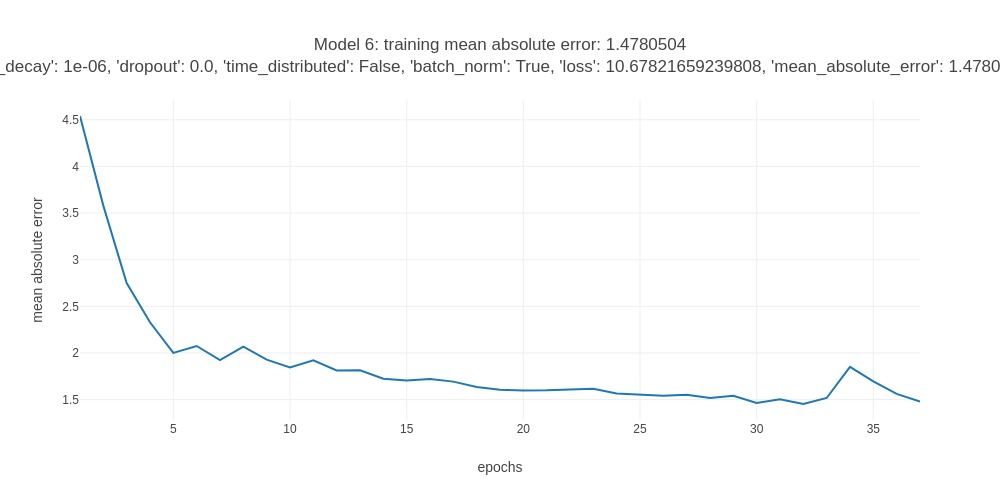

12-36-15 | INFO | models/model-6/20190603123615
INFO:CS230:models/model-6/20190603123615
12-36-15 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_47 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_36 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


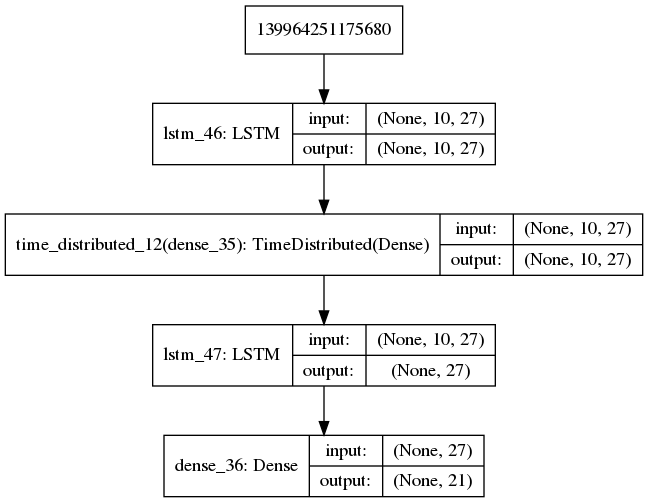

Epoch 1/200
 999/1002 [============================>.] - ETA: 0s - loss: 284.1206 - mean_absolute_error: 4.6567
Epoch 00001: loss improved from inf to 284.09725, saving model to models/model-6/20190603123615/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 283.9463 - mean_absolute_error: 4.6586
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 177.8933 - mean_absolute_error: 3.9344
Epoch 00002: loss improved from 284.09725 to 177.70127, saving model to models/model-6/20190603123615/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 177.6076 - mean_absolute_error: 3.9328
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 101.4428 - mean_absolute_error: 3.4135
Epoch 00003: loss improved from 177.70127 to 101.44812, saving model to models/model-6/20190603123615/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 101.3980 - mean_absolute_error: 3.4161
Epoch 4/200
1000

Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 10.0013 - mean_absolute_error: 1.3541
Epoch 00027: loss did not improve from 9.72206
1002/1002 [==============================] - 19s 19ms/step - loss: 9.9913 - mean_absolute_error: 1.3540
Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 9.3809 - mean_absolute_error: 1.3288
Epoch 00028: loss improved from 9.72206 to 9.37347, saving model to models/model-6/20190603123615/epoch28.h5
1002/1002 [==============================] - 20s 19ms/step - loss: 9.3683 - mean_absolute_error: 1.3286
Epoch 29/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.4230 - mean_absolute_error: 1.3366
Epoch 00029: loss did not improve from 9.37347
1002/1002 [==============================] - 19s 19ms/step - loss: 9.4043 - mean_absolute_error: 1.3343
Epoch 30/200
1001/1002 [============================>.] - ETA: 0s - loss: 9.4259 - mean_absolute_error: 1.3344
Epoch 00030: loss did not improve from 9

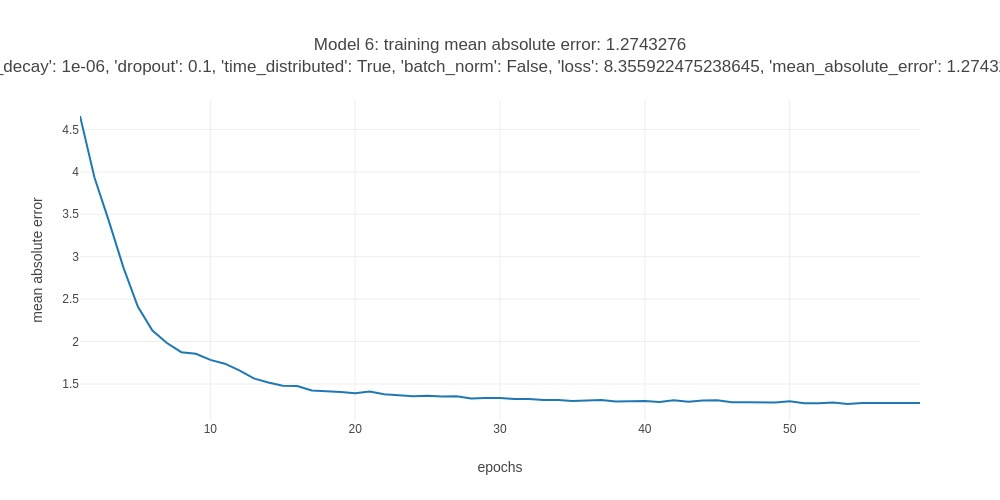

12-55-44 | INFO | models/model-6/20190603125544
INFO:CS230:models/model-6/20190603125544
12-55-44 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_12 (B (None, 10, 27)            108       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_49 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_38 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


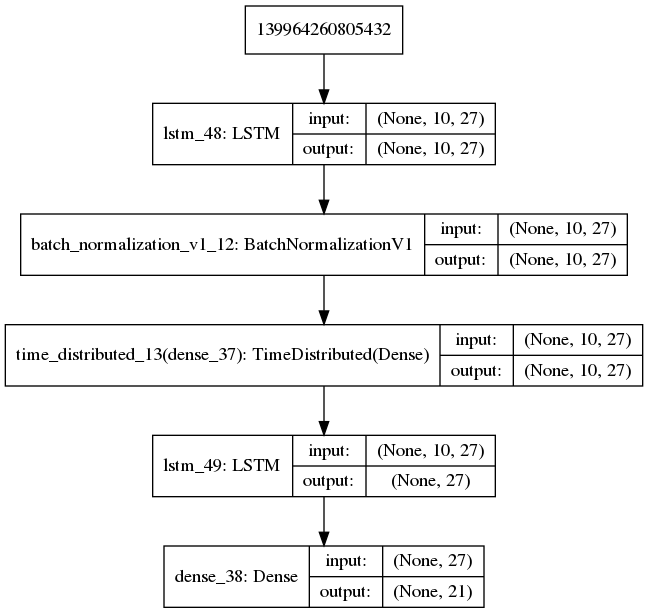

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 327.7820 - mean_absolute_error: 5.2079
Epoch 00001: loss improved from inf to 327.57722, saving model to models/model-6/20190603125544/epoch1.h5
1002/1002 [==============================] - 25s 25ms/step - loss: 327.4184 - mean_absolute_error: 5.2067
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 280.4605 - mean_absolute_error: 4.5924
Epoch 00002: loss improved from 327.57722 to 281.07530, saving model to models/model-6/20190603125544/epoch2.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 280.9229 - mean_absolute_error: 4.5964
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 177.2279 - mean_absolute_error: 3.9125
Epoch 00003: loss improved from 281.07530 to 177.89946, saving model to models/model-6/20190603125544/epoch3.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 177.8064 - mean_absolute_error: 3.9144
Epoch 4/200
1000

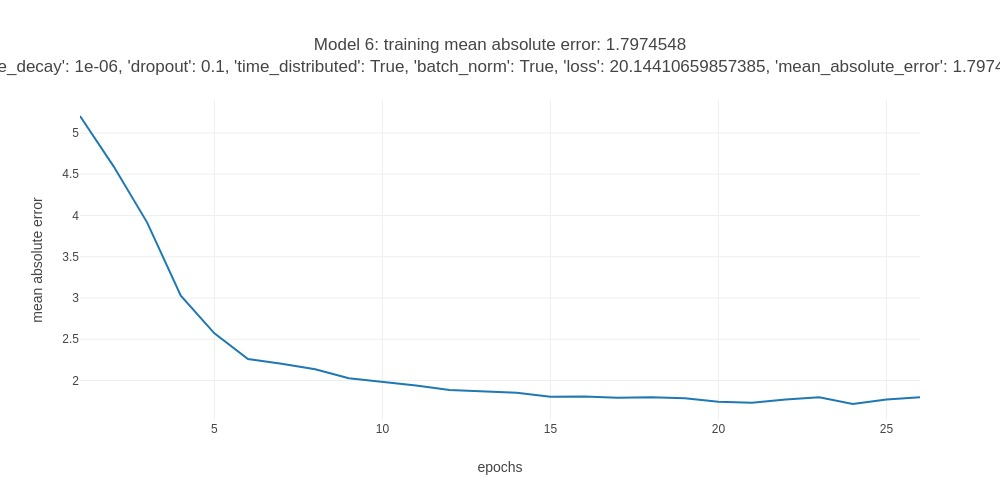

13-04-39 | INFO | models/model-6/20190603130439
INFO:CS230:models/model-6/20190603130439
13-04-39 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_51 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_39 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


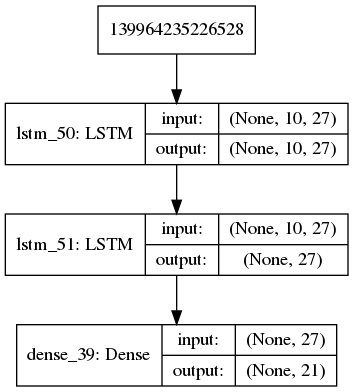

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 191.8249 - mean_absolute_error: 3.8964
Epoch 00001: loss improved from inf to 191.82263, saving model to models/model-6/20190603130439/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 191.7189 - mean_absolute_error: 3.9012
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 57.4739 - mean_absolute_error: 2.5499
Epoch 00002: loss improved from 191.82263 to 57.43306, saving model to models/model-6/20190603130439/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 57.4011 - mean_absolute_error: 2.5503
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 29.3304 - mean_absolute_error: 2.0780
Epoch 00003: loss improved from 57.43306 to 29.30122, saving model to models/model-6/20190603130439/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 29.2850 - mean_absolute_error: 2.0764
Epoch 4/200
1000/1002 [

Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 8.7702 - mean_absolute_error: 1.2863
Epoch 00028: loss improved from 8.91776 to 8.76814, saving model to models/model-6/20190603130439/epoch28.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 8.7633 - mean_absolute_error: 1.2870
Epoch 29/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.8605 - mean_absolute_error: 1.2885
Epoch 00029: loss did not improve from 8.76814
1002/1002 [==============================] - 19s 19ms/step - loss: 8.8619 - mean_absolute_error: 1.2889
Epoch 30/200
 999/1002 [============================>.] - ETA: 0s - loss: 8.7794 - mean_absolute_error: 1.2823
Epoch 00030: loss did not improve from 8.76814
1002/1002 [==============================] - 19s 19ms/step - loss: 8.7846 - mean_absolute_error: 1.2830
Epoch 31/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.7237 - mean_absolute_error: 1.2830
Epoch 00031: loss improved from 8.76814 t

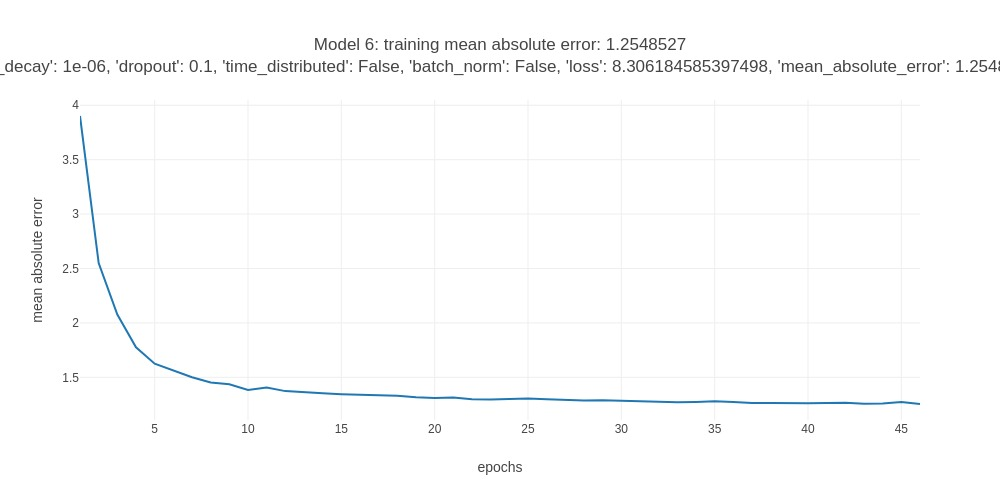

13-19-44 | INFO | models/model-6/20190603131944
INFO:CS230:models/model-6/20190603131944
13-19-44 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.01, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 10, 27)            108       
_________________________________________________________________
lstm_53 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_40 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


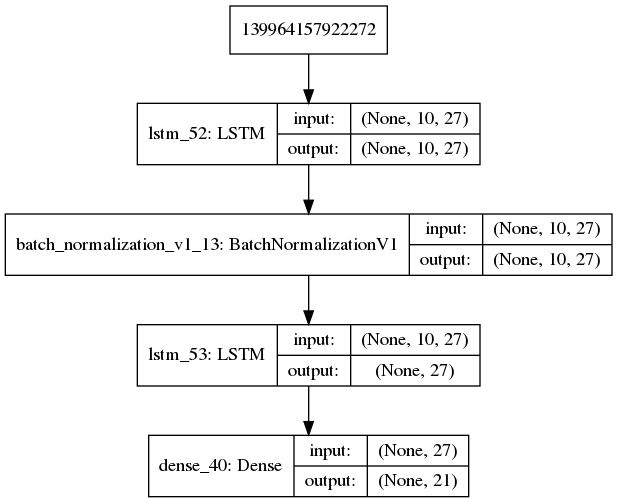

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 290.1254 - mean_absolute_error: 4.6233
Epoch 00001: loss improved from inf to 289.71438, saving model to models/model-6/20190603131944/epoch1.h5
1002/1002 [==============================] - 24s 24ms/step - loss: 289.5680 - mean_absolute_error: 4.6175
Epoch 2/200
 999/1002 [============================>.] - ETA: 0s - loss: 153.5569 - mean_absolute_error: 3.6306
Epoch 00002: loss improved from 289.71438 to 153.47402, saving model to models/model-6/20190603131944/epoch2.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 153.3894 - mean_absolute_error: 3.6297
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 76.7499 - mean_absolute_error: 2.7541
Epoch 00003: loss improved from 153.47402 to 76.82379, saving model to models/model-6/20190603131944/epoch3.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 76.7809 - mean_absolute_error: 2.7551
Epoch 4/200
 999/10

Epoch 00027: early stopping
Response: ok
Response code: 200
Response: ok
Response code: 200


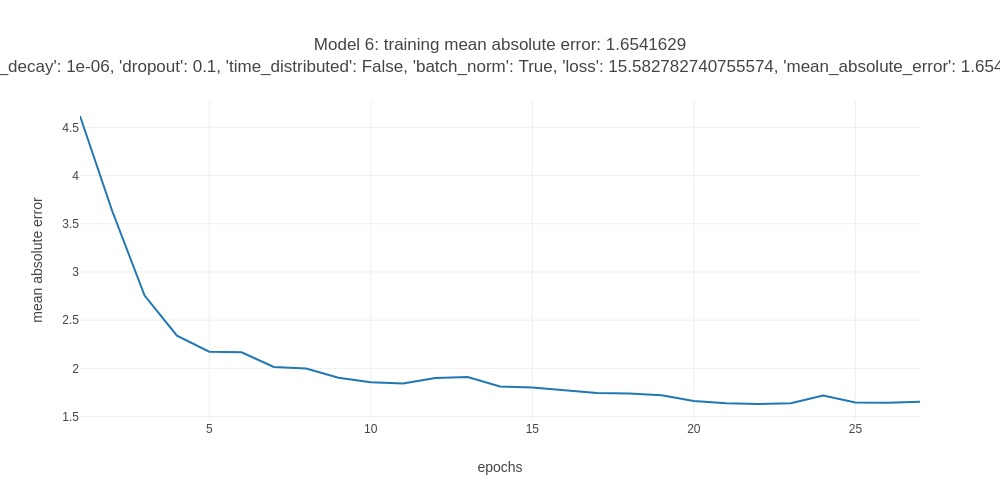

13-29-01 | INFO | models/model-6/20190603132901
INFO:CS230:models/model-6/20190603132901
13-29-01 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_55 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_42 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


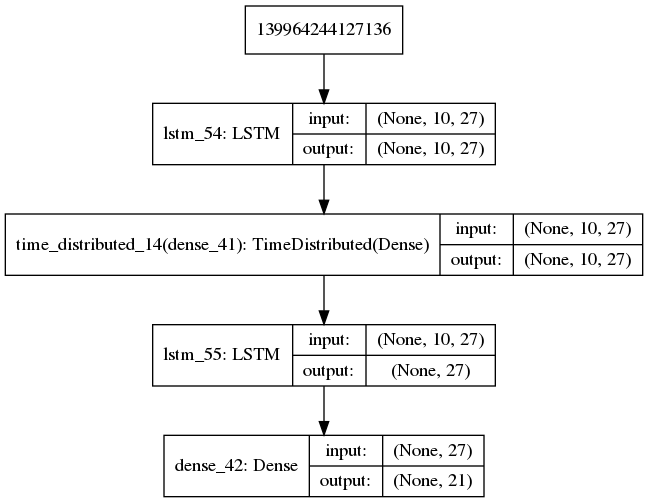

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 339.0698 - mean_absolute_error: 5.4356
Epoch 00001: loss improved from inf to 338.60467, saving model to models/model-6/20190603132901/epoch1.h5
1002/1002 [==============================] - 22s 22ms/step - loss: 338.4327 - mean_absolute_error: 5.4292
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 302.7759 - mean_absolute_error: 4.5959
Epoch 00002: loss improved from 338.60467 to 302.36235, saving model to models/model-6/20190603132901/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 302.1938 - mean_absolute_error: 4.5905
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 262.8336 - mean_absolute_error: 3.9128
Epoch 00003: loss improved from 302.36235 to 262.46129, saving model to models/model-6/20190603132901/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 262.3143 - mean_absolute_error: 3.9070
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.3155 - mean_absolute_error: 1.1992
Epoch 00026: loss improved from 8.80113 to 8.30858, saving model to models/model-6/20190603132901/epoch26.h5
1002/1002 [==============================] - 18s 17ms/step - loss: 8.3039 - mean_absolute_error: 1.1984
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.6829 - mean_absolute_error: 1.1683
Epoch 00027: loss improved from 8.30858 to 7.67712, saving model to models/model-6/20190603132901/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 7.6728 - mean_absolute_error: 1.1676
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.5770 - mean_absolute_error: 1.1723
Epoch 00028: loss improved from 7.67712 to 7.57147, saving model to models/model-6/20190603132901/epoch28.h5
1002/1002 [==============================] - 18s 17ms/step - loss: 7.5673 - mean_absolute_error: 1.1717
Epoch 29/200
1000/1002 [====

Epoch 54/200
 999/1002 [============================>.] - ETA: 0s - loss: 5.7198 - mean_absolute_error: 1.0348
Epoch 00054: loss did not improve from 5.69604
1002/1002 [==============================] - 18s 17ms/step - loss: 5.7131 - mean_absolute_error: 1.0350
Epoch 55/200
 999/1002 [============================>.] - ETA: 0s - loss: 5.7303 - mean_absolute_error: 1.0362
Epoch 00055: loss did not improve from 5.69604
1002/1002 [==============================] - 18s 18ms/step - loss: 5.7234 - mean_absolute_error: 1.0360
Epoch 00055: early stopping
Response: ok
Response code: 200
Response: ok
Response code: 200
Response: ok
Response code: 200


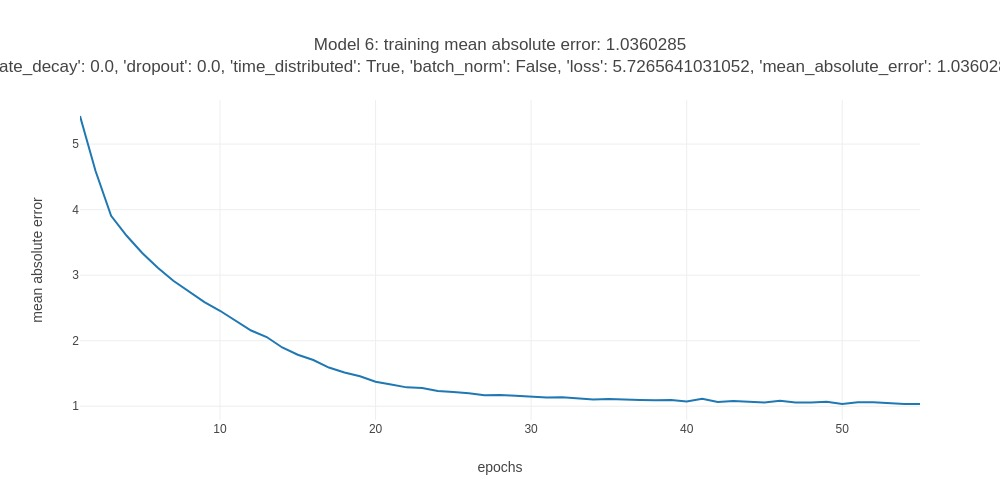

13-45-30 | INFO | models/model-6/20190603134530
INFO:CS230:models/model-6/20190603134530
13-45-30 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_14 (B (None, 10, 27)            108       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_57 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_44 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


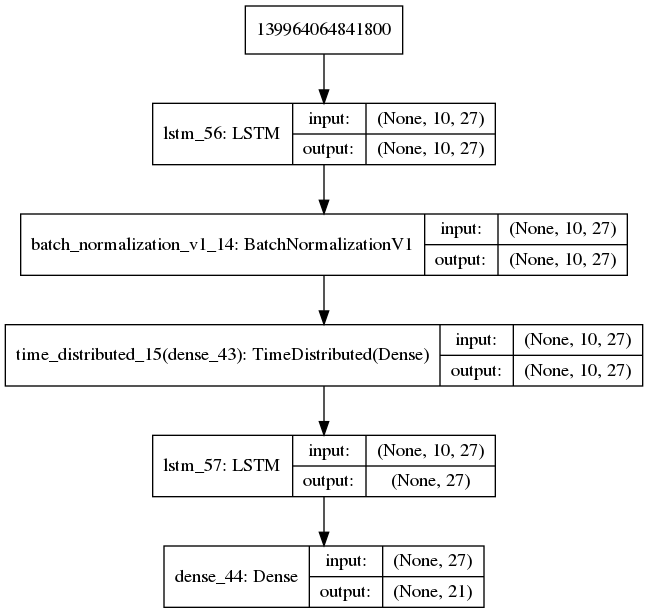

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 340.1530 - mean_absolute_error: 5.4409
Epoch 00001: loss improved from inf to 340.11091, saving model to models/model-6/20190603134530/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 339.9268 - mean_absolute_error: 5.4401
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 300.4506 - mean_absolute_error: 4.4647
Epoch 00002: loss improved from 340.11091 to 300.02157, saving model to models/model-6/20190603134530/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 299.8560 - mean_absolute_error: 4.4575
Epoch 3/200
1001/1002 [============================>.] - ETA: 0s - loss: 270.9158 - mean_absolute_error: 4.1087
Epoch 00003: loss improved from 300.02157 to 270.95894, saving model to models/model-6/20190603134530/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 270.8082 - mean_absolute_error: 4.1100
Epoch 4/200
1000

Epoch 26/200
 999/1002 [============================>.] - ETA: 0s - loss: 17.0962 - mean_absolute_error: 1.6636
Epoch 00026: loss improved from 17.99340 to 17.07959, saving model to models/model-6/20190603134530/epoch26.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 17.0701 - mean_absolute_error: 1.6634
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 16.5327 - mean_absolute_error: 1.6583
Epoch 00027: loss improved from 17.07959 to 16.50899, saving model to models/model-6/20190603134530/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 16.4998 - mean_absolute_error: 1.6553
Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 15.8339 - mean_absolute_error: 1.6376
Epoch 00028: loss improved from 16.50899 to 15.80578, saving model to models/model-6/20190603134530/epoch28.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 15.7969 - mean_absolute_error: 1.6353
Epoch 29/200
 99

Epoch 53/200
 999/1002 [============================>.] - ETA: 0s - loss: 10.1651 - mean_absolute_error: 1.3798
Epoch 00053: loss improved from 10.37805 to 10.15835, saving model to models/model-6/20190603134530/epoch53.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 10.1528 - mean_absolute_error: 1.3801
Epoch 54/200
1000/1002 [============================>.] - ETA: 0s - loss: 10.0066 - mean_absolute_error: 1.3736
Epoch 00054: loss improved from 10.15835 to 10.00575, saving model to models/model-6/20190603134530/epoch54.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 10.0002 - mean_absolute_error: 1.3732
Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.8377 - mean_absolute_error: 1.3548
Epoch 00055: loss improved from 10.00575 to 9.84848, saving model to models/model-6/20190603134530/epoch55.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 9.8430 - mean_absolute_error: 1.3562
Epoch 56/200
 999/1

Epoch 80/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.8659 - mean_absolute_error: 1.1678
Epoch 00080: loss did not improve from 6.73468
1002/1002 [==============================] - 18s 18ms/step - loss: 6.8644 - mean_absolute_error: 1.1678
Epoch 81/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.5737 - mean_absolute_error: 1.1398
Epoch 00081: loss improved from 6.73468 to 6.58011, saving model to models/model-6/20190603134530/epoch81.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 6.5764 - mean_absolute_error: 1.1401
Epoch 82/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.6359 - mean_absolute_error: 1.1408
Epoch 00082: loss did not improve from 6.58011
1002/1002 [==============================] - 18s 18ms/step - loss: 6.6332 - mean_absolute_error: 1.1409
Epoch 83/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.4727 - mean_absolute_error: 1.1295
Epoch 00083: loss improved from 6.58011 t

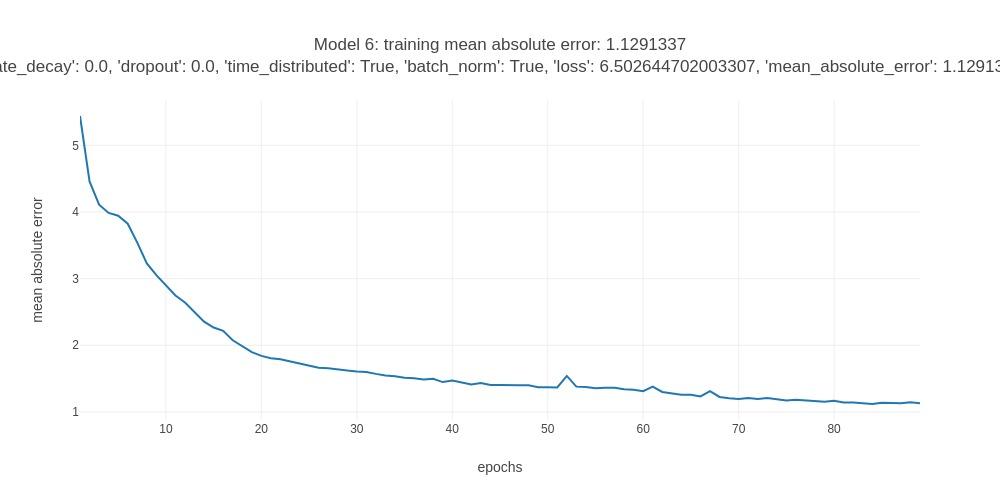

14-12-46 | INFO | models/model-6/20190603141246
INFO:CS230:models/model-6/20190603141246
14-12-46 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_59 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_45 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


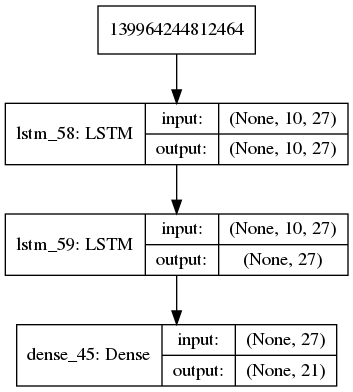

Epoch 1/200
1001/1002 [============================>.] - ETA: 0s - loss: 318.8365 - mean_absolute_error: 5.5472
Epoch 00001: loss improved from inf to 318.69745, saving model to models/model-6/20190603141246/epoch1.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 318.5203 - mean_absolute_error: 5.5424
Epoch 2/200
1001/1002 [============================>.] - ETA: 0s - loss: 257.4500 - mean_absolute_error: 4.2353
Epoch 00002: loss improved from 318.69745 to 257.33840, saving model to models/model-6/20190603141246/epoch2.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 257.1951 - mean_absolute_error: 4.2318
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 217.2811 - mean_absolute_error: 3.8182
Epoch 00003: loss improved from 257.33840 to 217.89299, saving model to models/model-6/20190603141246/epoch3.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 217.7718 - mean_absolute_error: 3.8234
Epoch 4/200
1000

Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.1785 - mean_absolute_error: 0.9553
Epoch 00055: loss improved from 5.25624 to 5.17506, saving model to models/model-6/20190603141246/epoch55.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 5.1722 - mean_absolute_error: 0.9549
Epoch 56/200
 999/1002 [============================>.] - ETA: 0s - loss: 5.2930 - mean_absolute_error: 0.9718
Epoch 00056: loss did not improve from 5.17506
1002/1002 [==============================] - 17s 17ms/step - loss: 5.2854 - mean_absolute_error: 0.9717
Epoch 57/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.2569 - mean_absolute_error: 0.9621
Epoch 00057: loss did not improve from 5.17506
1002/1002 [==============================] - 17s 17ms/step - loss: 5.2498 - mean_absolute_error: 0.9615
Epoch 58/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.2743 - mean_absolute_error: 0.9627
Epoch 00058: loss did not improve from 5.

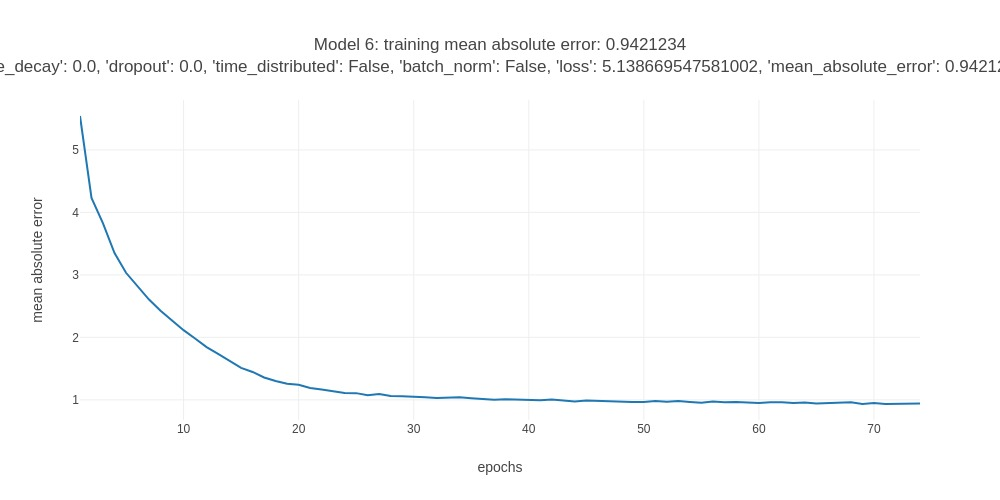

14-34-43 | INFO | models/model-6/20190603143443
INFO:CS230:models/model-6/20190603143443
14-34-43 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 10, 27)            108       
_________________________________________________________________
lstm_61 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_46 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


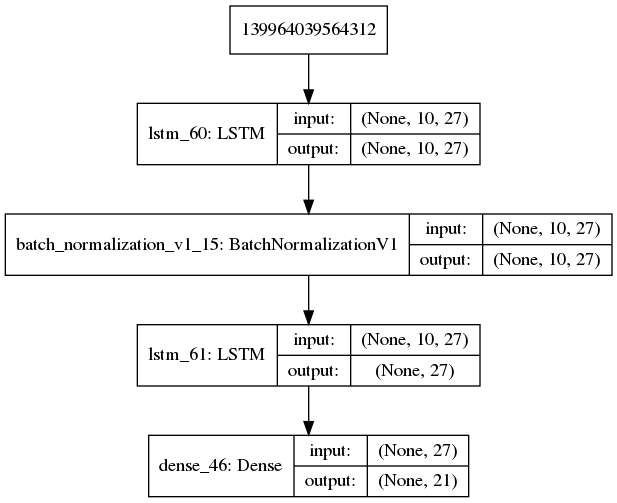

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 330.2080 - mean_absolute_error: 5.3074
Epoch 00001: loss improved from inf to 329.86555, saving model to models/model-6/20190603143443/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 329.6848 - mean_absolute_error: 5.3040
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 282.5540 - mean_absolute_error: 4.2728
Epoch 00002: loss improved from 329.86555 to 283.58831, saving model to models/model-6/20190603143443/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 283.4319 - mean_absolute_error: 4.2777
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 254.0793 - mean_absolute_error: 4.0981
Epoch 00003: loss improved from 283.58831 to 254.78594, saving model to models/model-6/20190603143443/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 254.6452 - mean_absolute_error: 4.1037
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 12.1719 - mean_absolute_error: 1.4550
Epoch 00026: loss improved from 13.27882 to 12.17415, saving model to models/model-6/20190603143443/epoch26.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 12.1673 - mean_absolute_error: 1.4561
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 11.6322 - mean_absolute_error: 1.4332
Epoch 00027: loss improved from 12.17415 to 11.61557, saving model to models/model-6/20190603143443/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 11.6091 - mean_absolute_error: 1.4307
Epoch 28/200
1001/1002 [============================>.] - ETA: 0s - loss: 11.0284 - mean_absolute_error: 1.4121
Epoch 00028: loss improved from 11.61557 to 11.02380, saving model to models/model-6/20190603143443/epoch28.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 11.0177 - mean_absolute_error: 1.4109
Epoch 29/200
 99

Epoch 53/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.4178 - mean_absolute_error: 1.1235
Epoch 00053: loss did not improve from 6.38831
1002/1002 [==============================] - 18s 18ms/step - loss: 6.4050 - mean_absolute_error: 1.1215
Epoch 54/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.3593 - mean_absolute_error: 1.1140
Epoch 00054: loss improved from 6.38831 to 6.36667, saving model to models/model-6/20190603143443/epoch54.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 6.3631 - mean_absolute_error: 1.1151
Epoch 55/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.2877 - mean_absolute_error: 1.1112
Epoch 00055: loss improved from 6.36667 to 6.29012, saving model to models/model-6/20190603143443/epoch55.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 6.2866 - mean_absolute_error: 1.1107
Epoch 56/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.2351 - mean_ab

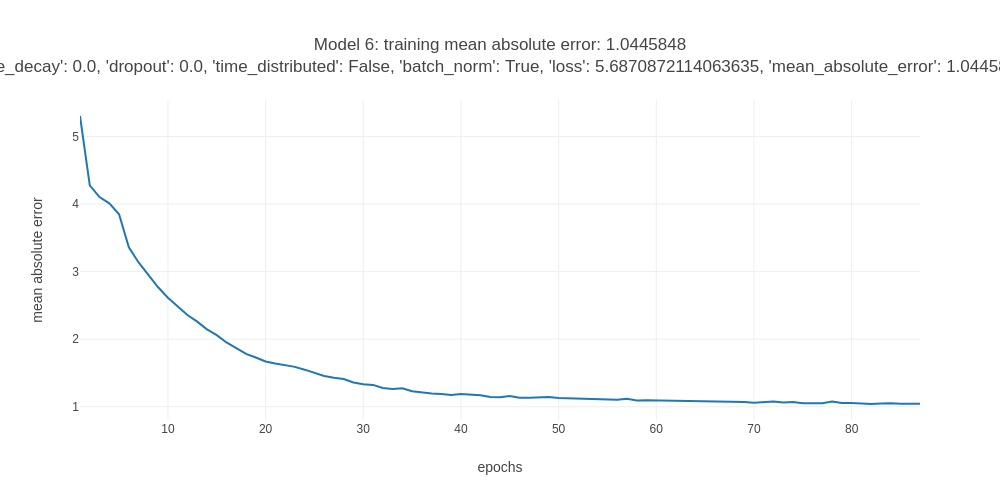

15-01-10 | INFO | models/model-6/20190603150110
INFO:CS230:models/model-6/20190603150110
15-01-10 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_63 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_48 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


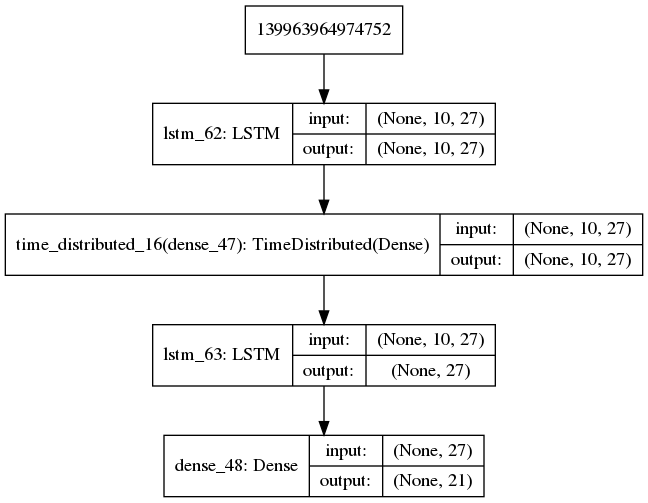

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 326.7980 - mean_absolute_error: 5.3499
Epoch 00001: loss improved from inf to 326.34586, saving model to models/model-6/20190603150110/epoch1.h5
1002/1002 [==============================] - 25s 25ms/step - loss: 326.1642 - mean_absolute_error: 5.3427
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 272.2218 - mean_absolute_error: 4.2264
Epoch 00002: loss improved from 326.34586 to 271.86320, saving model to models/model-6/20190603150110/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 271.7121 - mean_absolute_error: 4.2219
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 238.7190 - mean_absolute_error: 4.0415
Epoch 00003: loss improved from 271.86320 to 238.43337, saving model to models/model-6/20190603150110/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 238.3014 - mean_absolute_error: 4.0391
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.2155 - mean_absolute_error: 1.2374
Epoch 00026: loss improved from 8.55219 to 8.21421, saving model to models/model-6/20190603150110/epoch26.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 8.2097 - mean_absolute_error: 1.2371
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.0305 - mean_absolute_error: 1.2282
Epoch 00027: loss improved from 8.21421 to 8.02492, saving model to models/model-6/20190603150110/epoch27.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 8.0205 - mean_absolute_error: 1.2276
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.8822 - mean_absolute_error: 1.2193
Epoch 00028: loss improved from 8.02492 to 7.88255, saving model to models/model-6/20190603150110/epoch28.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 7.8782 - mean_absolute_error: 1.2189
Epoch 29/200
1000/1002 [====

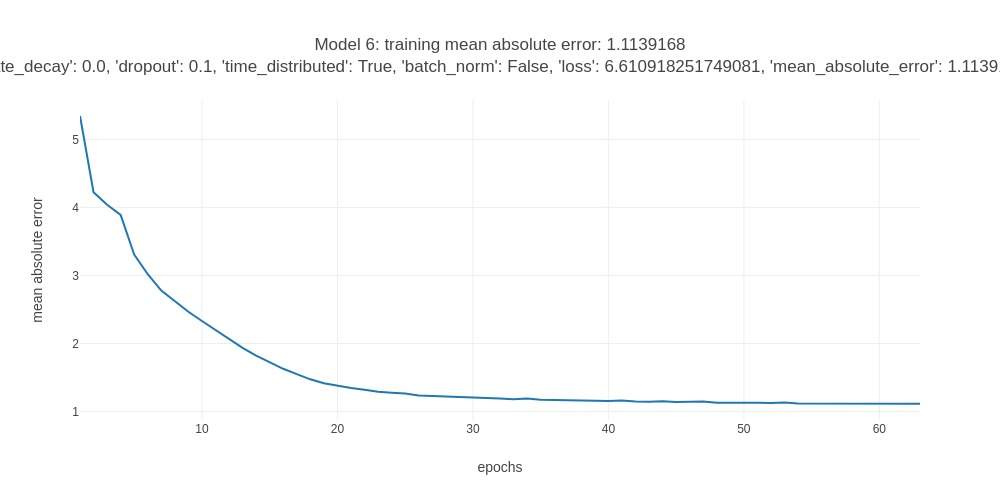

15-22-10 | INFO | models/model-6/20190603152210
INFO:CS230:models/model-6/20190603152210
15-22-10 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_16 (B (None, 10, 27)            108       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_65 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_50 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


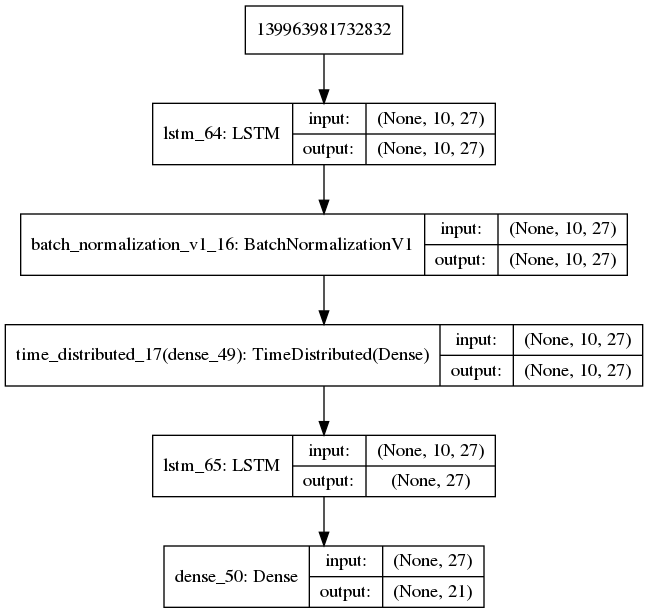

Epoch 1/200
1001/1002 [============================>.] - ETA: 0s - loss: 340.8558 - mean_absolute_error: 5.5192
Epoch 00001: loss improved from inf to 340.70655, saving model to models/model-6/20190603152210/epoch1.h5
1002/1002 [==============================] - 26s 26ms/step - loss: 340.5252 - mean_absolute_error: 5.5159
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 303.5394 - mean_absolute_error: 4.4776
Epoch 00002: loss improved from 340.70655 to 303.10226, saving model to models/model-6/20190603152210/epoch2.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 302.9367 - mean_absolute_error: 4.4703
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 271.3154 - mean_absolute_error: 4.0890
Epoch 00003: loss improved from 303.10226 to 270.97889, saving model to models/model-6/20190603152210/epoch3.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 270.8281 - mean_absolute_error: 4.0853
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 17.3580 - mean_absolute_error: 1.6820
Epoch 00026: loss improved from 17.99857 to 17.36415, saving model to models/model-6/20190603152210/epoch26.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 17.3545 - mean_absolute_error: 1.6834
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 16.3598 - mean_absolute_error: 1.6459
Epoch 00027: loss improved from 17.36415 to 16.33692, saving model to models/model-6/20190603152210/epoch27.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 16.3279 - mean_absolute_error: 1.6433
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 15.8422 - mean_absolute_error: 1.6297
Epoch 00028: loss improved from 16.33692 to 15.83192, saving model to models/model-6/20190603152210/epoch28.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 15.8231 - mean_absolute_error: 1.6291
Epoch 29/200
100

Epoch 53/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.6638 - mean_absolute_error: 1.3531
Epoch 00053: loss improved from 9.92288 to 9.65779, saving model to models/model-6/20190603152210/epoch53.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 9.6525 - mean_absolute_error: 1.3524
Epoch 54/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.8815 - mean_absolute_error: 1.3540
Epoch 00054: loss did not improve from 9.65779
1002/1002 [==============================] - 20s 20ms/step - loss: 9.8926 - mean_absolute_error: 1.3547
Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.2125 - mean_absolute_error: 1.3340
Epoch 00055: loss improved from 9.65779 to 9.19937, saving model to models/model-6/20190603152210/epoch55.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 9.1943 - mean_absolute_error: 1.3317
Epoch 56/200
1000/1002 [============================>.] - ETA: 0s - loss: 9.4162 - mean_ab

Epoch 81/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.9141 - mean_absolute_error: 1.2320
Epoch 00081: loss did not improve from 7.57010
1002/1002 [==============================] - 20s 20ms/step - loss: 7.9102 - mean_absolute_error: 1.2322
Epoch 82/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.7949 - mean_absolute_error: 1.2218
Epoch 00082: loss did not improve from 7.57010
1002/1002 [==============================] - 20s 20ms/step - loss: 7.7939 - mean_absolute_error: 1.2229
Epoch 83/200
 999/1002 [============================>.] - ETA: 0s - loss: 7.5158 - mean_absolute_error: 1.2167
Epoch 00083: loss improved from 7.57010 to 7.51522, saving model to models/model-6/20190603152210/epoch83.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 7.5111 - mean_absolute_error: 1.2172
Epoch 84/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.8645 - mean_absolute_error: 1.2242
Epoch 00084: loss did not improve from 7.

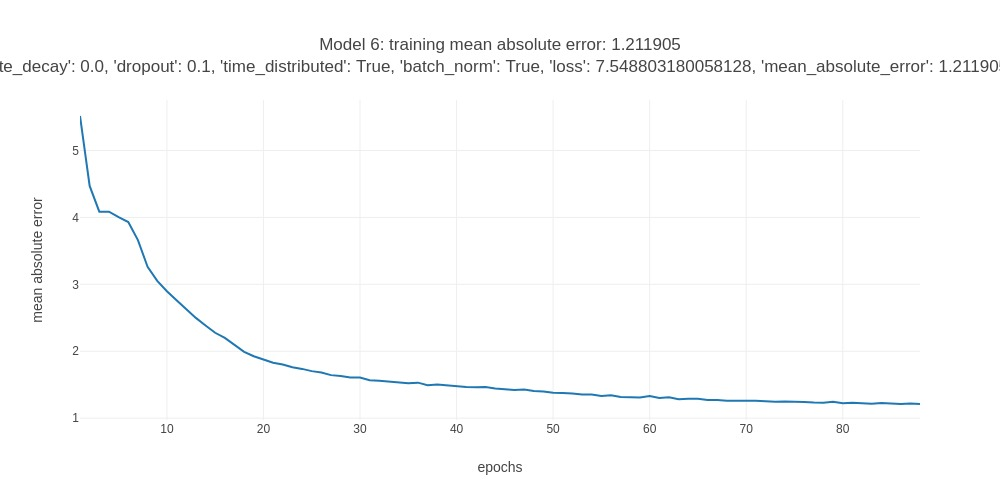

15-52-03 | INFO | models/model-6/20190603155203
INFO:CS230:models/model-6/20190603155203
15-52-03 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_67 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_51 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


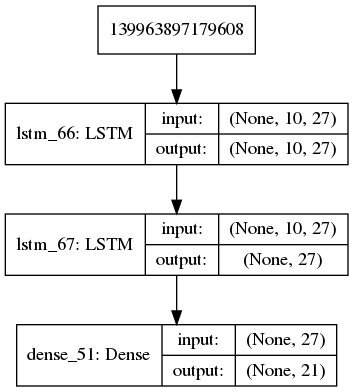

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 315.5548 - mean_absolute_error: 5.6049
Epoch 00001: loss improved from inf to 316.36249, saving model to models/model-6/20190603155203/epoch1.h5
1002/1002 [==============================] - 24s 24ms/step - loss: 316.1870 - mean_absolute_error: 5.6096
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 250.6125 - mean_absolute_error: 4.2777
Epoch 00002: loss improved from 316.36249 to 250.28189, saving model to models/model-6/20190603155203/epoch2.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 250.1430 - mean_absolute_error: 4.2743
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 207.1791 - mean_absolute_error: 3.6424
Epoch 00003: loss improved from 250.28189 to 207.74134, saving model to models/model-6/20190603155203/epoch3.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 207.6251 - mean_absolute_error: 3.6461
Epoch 4/200
1000

 999/1002 [============================>.] - ETA: 0s - loss: 8.4191 - mean_absolute_error: 1.2497
Epoch 00026: loss improved from 8.53959 to 8.43175, saving model to models/model-6/20190603155203/epoch26.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 8.4271 - mean_absolute_error: 1.2505
Epoch 27/200
1001/1002 [============================>.] - ETA: 0s - loss: 8.2610 - mean_absolute_error: 1.2342
Epoch 00027: loss improved from 8.43175 to 8.29078, saving model to models/model-6/20190603155203/epoch27.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 8.2862 - mean_absolute_error: 1.2358
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.9971 - mean_absolute_error: 1.2248
Epoch 00028: loss improved from 8.29078 to 8.00247, saving model to models/model-6/20190603155203/epoch28.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 7.9980 - mean_absolute_error: 1.2251
Epoch 29/200
1000/1002 [=================

Epoch 54/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.1358 - mean_absolute_error: 1.1409
Epoch 00054: loss did not improve from 6.98599
1002/1002 [==============================] - 19s 19ms/step - loss: 7.1273 - mean_absolute_error: 1.1404
Epoch 55/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.9880 - mean_absolute_error: 1.1319
Epoch 00055: loss did not improve from 6.98599
1002/1002 [==============================] - 19s 19ms/step - loss: 6.9863 - mean_absolute_error: 1.1335
Epoch 56/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.9322 - mean_absolute_error: 1.1347
Epoch 00056: loss did not improve from 6.98599
1002/1002 [==============================] - 19s 19ms/step - loss: 7.0246 - mean_absolute_error: 1.1355
Epoch 57/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.9650 - mean_absolute_error: 1.1328
Epoch 00057: loss improved from 6.98599 to 6.95981, saving model to models/model-6/20190603155203/epoch

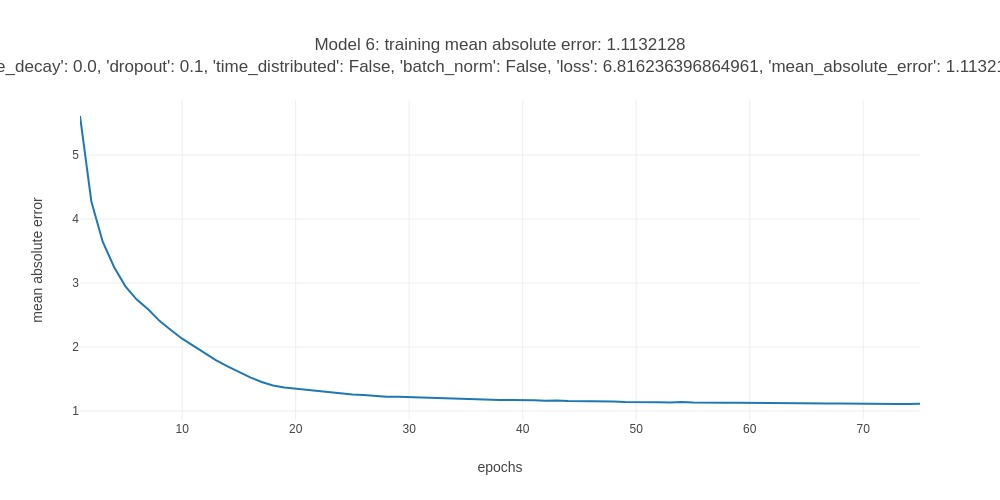

16-16-47 | INFO | models/model-6/20190603161647
INFO:CS230:models/model-6/20190603161647
16-16-47 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'dropout': 0.1, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_17 (B (None, 10, 27)            108       
_________________________________________________________________
lstm_69 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_52 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


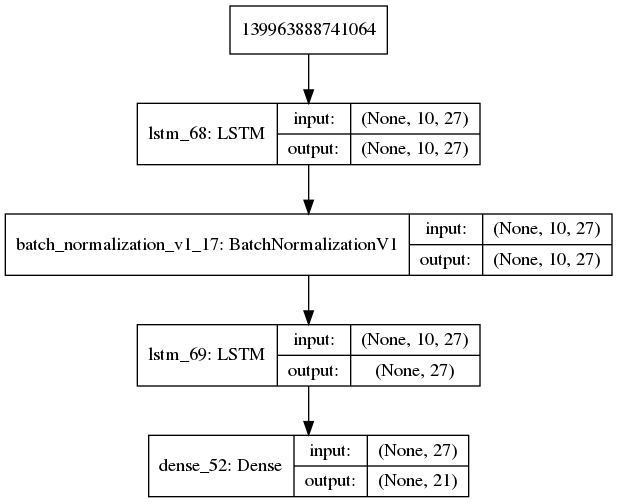

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 331.6036 - mean_absolute_error: 5.2610
Epoch 00001: loss improved from inf to 331.13157, saving model to models/model-6/20190603161647/epoch1.h5
1002/1002 [==============================] - 26s 26ms/step - loss: 330.9504 - mean_absolute_error: 5.2528
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 286.9761 - mean_absolute_error: 4.2309
Epoch 00002: loss improved from 331.13157 to 286.56582, saving model to models/model-6/20190603161647/epoch2.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 286.4071 - mean_absolute_error: 4.2240
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 258.6664 - mean_absolute_error: 4.0431
Epoch 00003: loss improved from 286.56582 to 258.29910, saving model to models/model-6/20190603161647/epoch3.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 258.1553 - mean_absolute_error: 4.0367
Epoch 4/200
 999

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 15.8434 - mean_absolute_error: 1.6378
Epoch 00026: loss improved from 16.56153 to 15.87404, saving model to models/model-6/20190603161647/epoch26.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 15.8652 - mean_absolute_error: 1.6382
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 15.1060 - mean_absolute_error: 1.6149
Epoch 00027: loss improved from 15.87404 to 15.09192, saving model to models/model-6/20190603161647/epoch27.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 15.0835 - mean_absolute_error: 1.6138
Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 14.6327 - mean_absolute_error: 1.5997
Epoch 00028: loss improved from 15.09192 to 14.61839, saving model to models/model-6/20190603161647/epoch28.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 14.6103 - mean_absolute_error: 1.5979
Epoch 29/200
 99

Epoch 79/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.5531 - mean_absolute_error: 1.2107
Epoch 00079: loss improved from 7.59283 to 7.56208, saving model to models/model-6/20190603161647/epoch79.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 7.5579 - mean_absolute_error: 1.2122
Epoch 80/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.5288 - mean_absolute_error: 1.2161
Epoch 00080: loss improved from 7.56208 to 7.51817, saving model to models/model-6/20190603161647/epoch80.h5
1002/1002 [==============================] - 20s 20ms/step - loss: 7.5140 - mean_absolute_error: 1.2140
Epoch 81/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.6131 - mean_absolute_error: 1.2202
Epoch 00081: loss did not improve from 7.51817
1002/1002 [==============================] - 20s 20ms/step - loss: 7.6040 - mean_absolute_error: 1.2196
Epoch 82/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.5369 - mean_ab

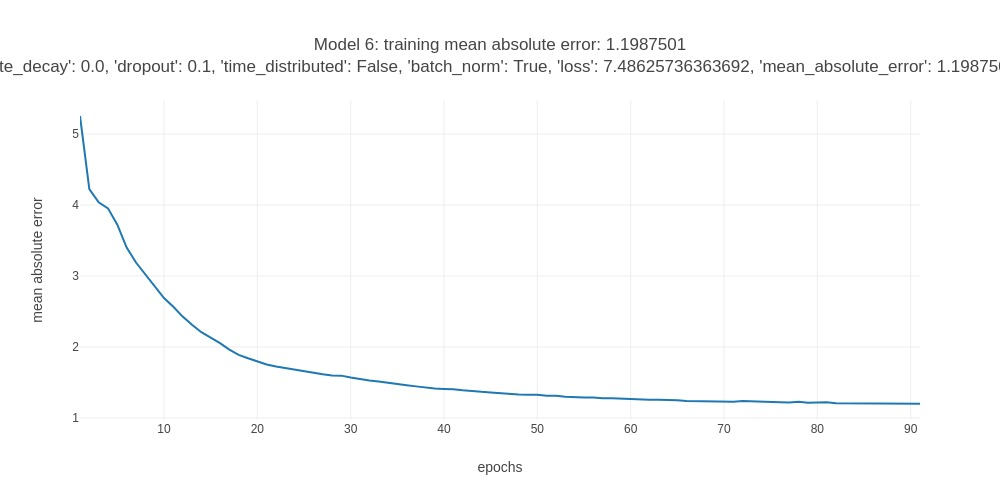

16-47-35 | INFO | models/model-6/20190603164735
INFO:CS230:models/model-6/20190603164735
16-47-35 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_71 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_54 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


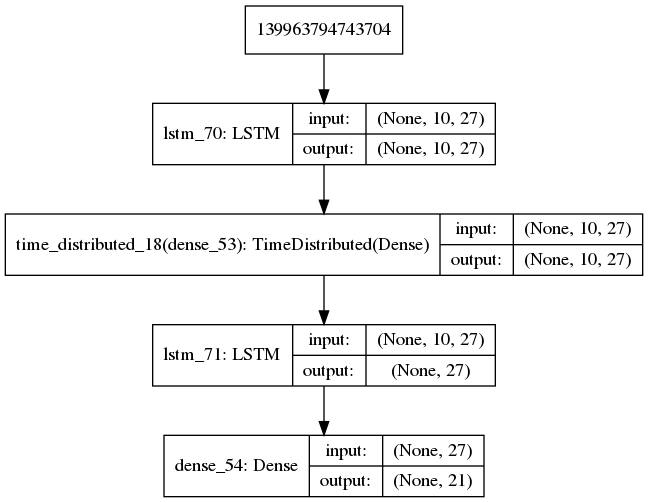

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 326.5019 - mean_absolute_error: 5.2933
Epoch 00001: loss improved from inf to 326.08688, saving model to models/model-6/20190603164735/epoch1.h5
1002/1002 [==============================] - 24s 24ms/step - loss: 325.9075 - mean_absolute_error: 5.2885
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 274.5085 - mean_absolute_error: 4.2704
Epoch 00002: loss improved from 326.08688 to 274.12066, saving model to models/model-6/20190603164735/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 273.9682 - mean_absolute_error: 4.2641
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 241.2380 - mean_absolute_error: 4.0215
Epoch 00003: loss improved from 274.12066 to 240.68498, saving model to models/model-6/20190603164735/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 240.5524 - mean_absolute_error: 4.0152
Epoch 4/200
1000

1000/1002 [============================>.] - ETA: 0s - loss: 7.2229 - mean_absolute_error: 1.1783
Epoch 00026: loss improved from 7.71547 to 7.24389, saving model to models/model-6/20190603164735/epoch26.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 7.2399 - mean_absolute_error: 1.1805
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.8747 - mean_absolute_error: 1.1474
Epoch 00027: loss improved from 7.24389 to 6.88300, saving model to models/model-6/20190603164735/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 6.8792 - mean_absolute_error: 1.1491
Epoch 28/200
1001/1002 [============================>.] - ETA: 0s - loss: 6.9574 - mean_absolute_error: 1.1458
Epoch 00028: loss did not improve from 6.88300
1002/1002 [==============================] - 18s 18ms/step - loss: 6.9693 - mean_absolute_error: 1.1470
Epoch 29/200
 999/1002 [============================>.] - ETA: 0s - loss: 6.5690 - mean_absolute_error:

Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.5657 - mean_absolute_error: 1.0194
Epoch 00055: loss did not improve from 5.49624
1002/1002 [==============================] - 18s 18ms/step - loss: 5.5614 - mean_absolute_error: 1.0194
Epoch 56/200
 999/1002 [============================>.] - ETA: 0s - loss: 5.7178 - mean_absolute_error: 1.0266
Epoch 00056: loss did not improve from 5.49624
1002/1002 [==============================] - 18s 18ms/step - loss: 5.7007 - mean_absolute_error: 1.0239
Epoch 57/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.5355 - mean_absolute_error: 1.0137
Epoch 00057: loss did not improve from 5.49624
1002/1002 [==============================] - 18s 18ms/step - loss: 5.5294 - mean_absolute_error: 1.0134
Epoch 00057: early stopping
Response: ok
Response code: 200
Response: ok
Response code: 200


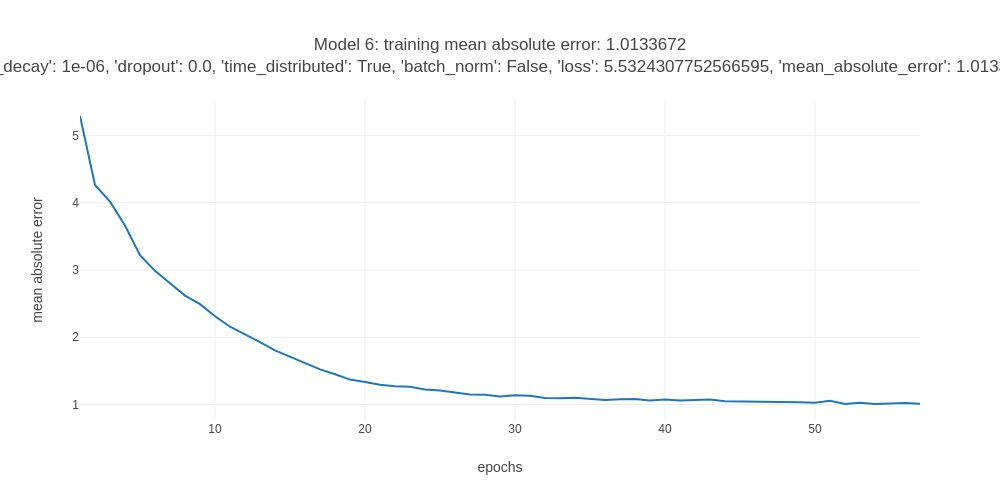

17-05-07 | INFO | models/model-6/20190603170507
INFO:CS230:models/model-6/20190603170507
17-05-07 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': True, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_18 (B (None, 10, 27)            108       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_73 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_56 (Dense)             (None, 21)                588       
Total params: 13,332
Trainable params: 13,278
Non-trainable params: 54
_________________________________________________________________


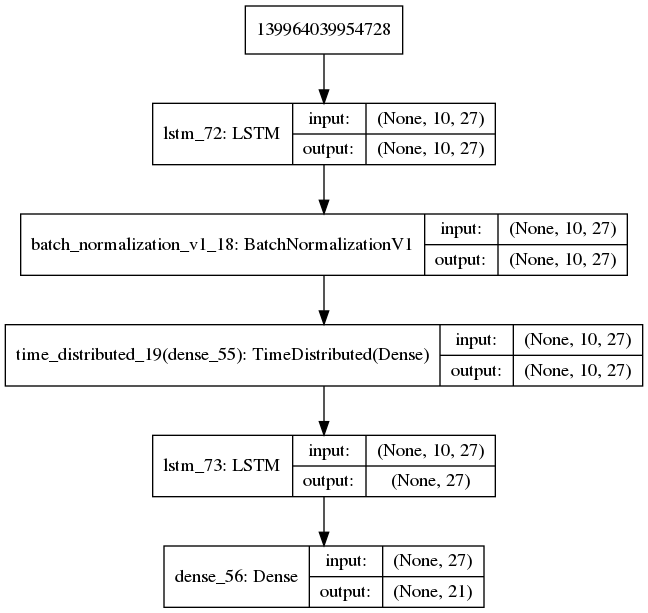

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 338.2022 - mean_absolute_error: 5.5185
Epoch 00001: loss improved from inf to 338.95410, saving model to models/model-6/20190603170507/epoch1.h5
1002/1002 [==============================] - 25s 25ms/step - loss: 338.7751 - mean_absolute_error: 5.5216
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 295.8008 - mean_absolute_error: 4.4532
Epoch 00002: loss improved from 338.95410 to 295.37668, saving model to models/model-6/20190603170507/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 295.2130 - mean_absolute_error: 4.4457
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 261.0506 - mean_absolute_error: 4.0841
Epoch 00003: loss improved from 295.37668 to 261.85465, saving model to models/model-6/20190603170507/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 261.7088 - mean_absolute_error: 4.0919
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 14.0984 - mean_absolute_error: 1.5799
Epoch 00026: loss improved from 14.86167 to 14.08667, saving model to models/model-6/20190603170507/epoch26.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 14.0788 - mean_absolute_error: 1.5789
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 13.8930 - mean_absolute_error: 1.5680
Epoch 00027: loss improved from 14.08667 to 13.92239, saving model to models/model-6/20190603170507/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 13.9146 - mean_absolute_error: 1.5691
Epoch 28/200
1000/1002 [============================>.] - ETA: 0s - loss: 13.3052 - mean_absolute_error: 1.5376
Epoch 00028: loss improved from 13.92239 to 13.30787, saving model to models/model-6/20190603170507/epoch28.h5
1002/1002 [==============================] - 19s 18ms/step - loss: 13.3004 - mean_absolute_error: 1.5390
Epoch 29/200
100

Epoch 53/200
1000/1002 [============================>.] - ETA: 0s - loss: 8.5467 - mean_absolute_error: 1.2949
Epoch 00053: loss improved from 8.86612 to 8.53448, saving model to models/model-6/20190603170507/epoch53.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 8.5297 - mean_absolute_error: 1.2926
Epoch 54/200
1001/1002 [============================>.] - ETA: 0s - loss: 8.3434 - mean_absolute_error: 1.2704
Epoch 00054: loss improved from 8.53448 to 8.35082, saving model to models/model-6/20190603170507/epoch54.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 8.3462 - mean_absolute_error: 1.2711
Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 7.9868 - mean_absolute_error: 1.2534
Epoch 00055: loss improved from 8.35082 to 7.98313, saving model to models/model-6/20190603170507/epoch55.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 7.9787 - mean_absolute_error: 1.2530
Epoch 56/200
1000/1002 [====

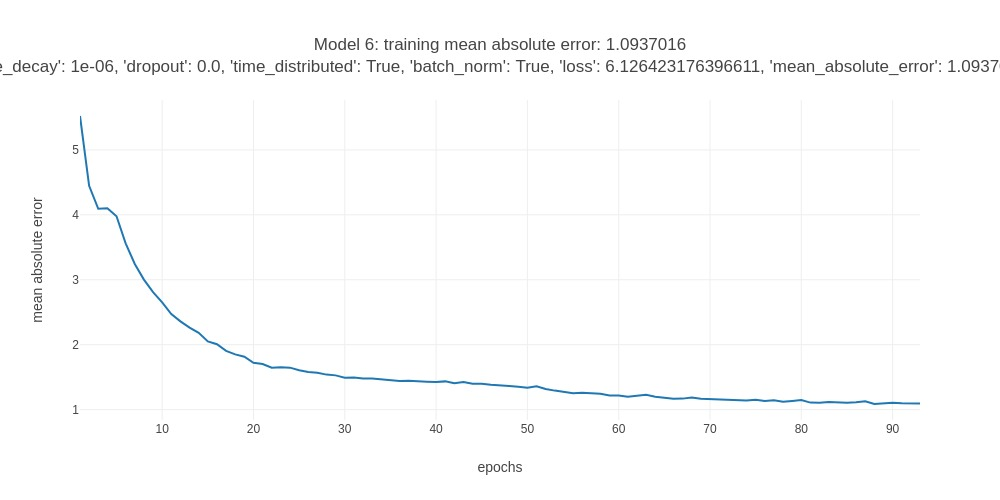

17-34-07 | INFO | models/model-6/20190603173407
INFO:CS230:models/model-6/20190603173407
17-34-07 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
lstm_75 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_57 (Dense)             (None, 21)                588       
Total params: 12,468
Trainable params: 12,468
Non-trainable params: 0
_________________________________________________________________


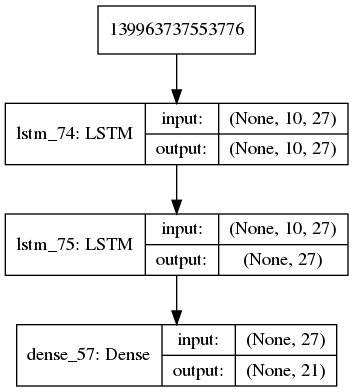

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 324.8945 - mean_absolute_error: 5.4263
Epoch 00001: loss improved from inf to 324.49662, saving model to models/model-6/20190603173407/epoch1.h5
1002/1002 [==============================] - 23s 23ms/step - loss: 324.3188 - mean_absolute_error: 5.4208
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 267.1993 - mean_absolute_error: 4.2909
Epoch 00002: loss improved from 324.49662 to 266.90364, saving model to models/model-6/20190603173407/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 266.7555 - mean_absolute_error: 4.2890
Epoch 3/200
 999/1002 [============================>.] - ETA: 0s - loss: 226.6541 - mean_absolute_error: 3.8340
Epoch 00003: loss improved from 266.90364 to 226.13293, saving model to models/model-6/20190603173407/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 226.0068 - mean_absolute_error: 3.8269
Epoch 4/200
 999

 999/1002 [============================>.] - ETA: 0s - loss: 5.5731 - mean_absolute_error: 0.9986
Epoch 00054: loss did not improve from 5.37245
1002/1002 [==============================] - 18s 18ms/step - loss: 5.5604 - mean_absolute_error: 0.9971
Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.2773 - mean_absolute_error: 0.9771
Epoch 00055: loss improved from 5.37245 to 5.28160, saving model to models/model-6/20190603173407/epoch55.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 5.2787 - mean_absolute_error: 0.9782
Epoch 56/200
 999/1002 [============================>.] - ETA: 0s - loss: 5.3380 - mean_absolute_error: 0.9808
Epoch 00056: loss did not improve from 5.28160
1002/1002 [==============================] - 18s 18ms/step - loss: 5.3331 - mean_absolute_error: 0.9810
Epoch 57/200
1000/1002 [============================>.] - ETA: 0s - loss: 5.3993 - mean_absolute_error: 0.9789
Epoch 00057: loss did not improve from 5.28160
1002/10

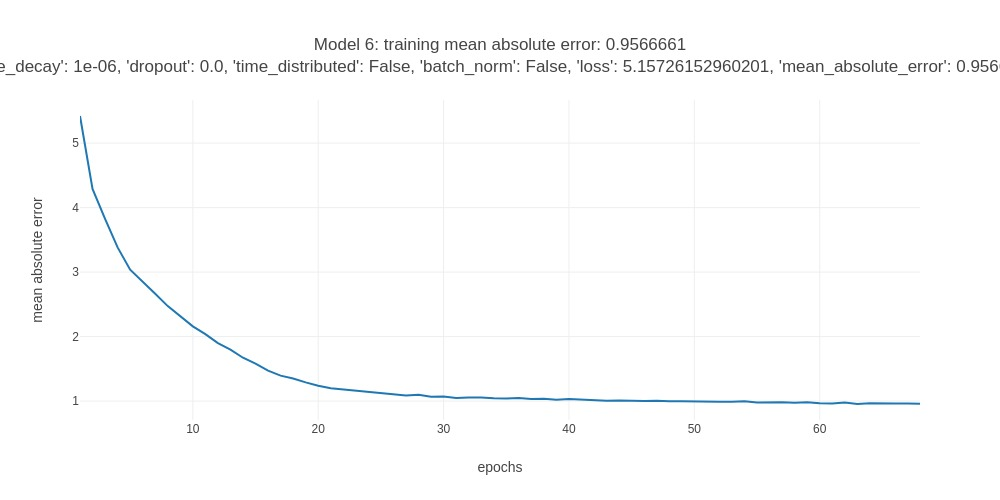

17-54-46 | INFO | models/model-6/20190603175446
INFO:CS230:models/model-6/20190603175446
17-54-46 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.0, 'time_distributed': False, 'batch_norm': True}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
batch_normalization_v1_19 (B (None, 10, 27)            108       
_________________________________________________________________
lstm_77 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_58 (Dense)             (None, 21)                588       
Total params: 12,576
Trainable params: 12,522
Non-trainable params: 54
_________________________________________________________________


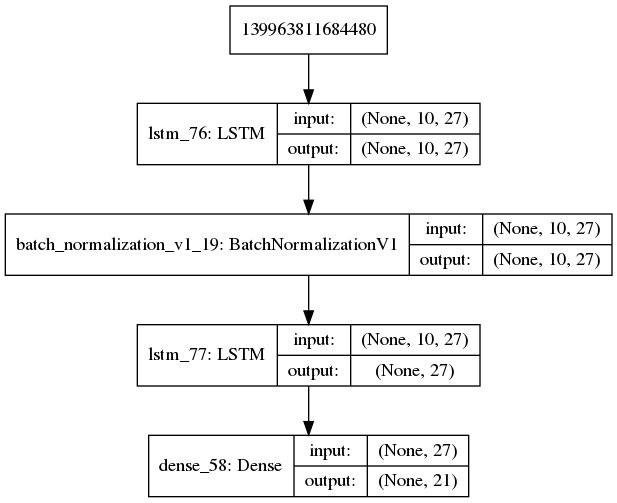

Epoch 1/200
1000/1002 [============================>.] - ETA: 0s - loss: 329.4982 - mean_absolute_error: 5.4133
Epoch 00001: loss improved from inf to 329.04708, saving model to models/model-6/20190603175446/epoch1.h5
1002/1002 [==============================] - 25s 25ms/step - loss: 328.8677 - mean_absolute_error: 5.4068
Epoch 2/200
1000/1002 [============================>.] - ETA: 0s - loss: 279.1450 - mean_absolute_error: 4.1525
Epoch 00002: loss improved from 329.04708 to 278.74779, saving model to models/model-6/20190603175446/epoch2.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 278.5922 - mean_absolute_error: 4.1459
Epoch 3/200
1000/1002 [============================>.] - ETA: 0s - loss: 247.1448 - mean_absolute_error: 3.8969
Epoch 00003: loss improved from 278.74779 to 246.85348, saving model to models/model-6/20190603175446/epoch3.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 246.7157 - mean_absolute_error: 3.8942
Epoch 4/200
1000

Epoch 26/200
1000/1002 [============================>.] - ETA: 0s - loss: 12.7671 - mean_absolute_error: 1.4761
Epoch 00026: loss improved from 13.68469 to 12.77997, saving model to models/model-6/20190603175446/epoch26.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 12.7728 - mean_absolute_error: 1.4782
Epoch 27/200
1000/1002 [============================>.] - ETA: 0s - loss: 12.0549 - mean_absolute_error: 1.4546
Epoch 00027: loss improved from 12.77997 to 12.03768, saving model to models/model-6/20190603175446/epoch27.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 12.0310 - mean_absolute_error: 1.4520
Epoch 28/200
 999/1002 [============================>.] - ETA: 0s - loss: 11.3643 - mean_absolute_error: 1.4335
Epoch 00028: loss improved from 12.03768 to 11.38666, saving model to models/model-6/20190603175446/epoch28.h5
1002/1002 [==============================] - 18s 18ms/step - loss: 11.3803 - mean_absolute_error: 1.4367
Epoch 29/200
100

Epoch 52/200
1001/1002 [============================>.] - ETA: 0s - loss: 6.5785 - mean_absolute_error: 1.1420
Epoch 00052: loss did not improve from 6.52310
1002/1002 [==============================] - 18s 18ms/step - loss: 6.5720 - mean_absolute_error: 1.1410
Epoch 53/200
1001/1002 [============================>.] - ETA: 0s - loss: 6.3980 - mean_absolute_error: 1.1262
Epoch 00053: loss improved from 6.52310 to 6.40200, saving model to models/model-6/20190603175446/epoch53.h5
1002/1002 [==============================] - 19s 19ms/step - loss: 6.3984 - mean_absolute_error: 1.1269
Epoch 54/200
1001/1002 [============================>.] - ETA: 0s - loss: 6.4917 - mean_absolute_error: 1.1348
Epoch 00054: loss did not improve from 6.40200
1002/1002 [==============================] - 19s 19ms/step - loss: 6.4919 - mean_absolute_error: 1.1353
Epoch 55/200
1000/1002 [============================>.] - ETA: 0s - loss: 6.4451 - mean_absolute_error: 1.1296
Epoch 00055: loss did not improve from 6.

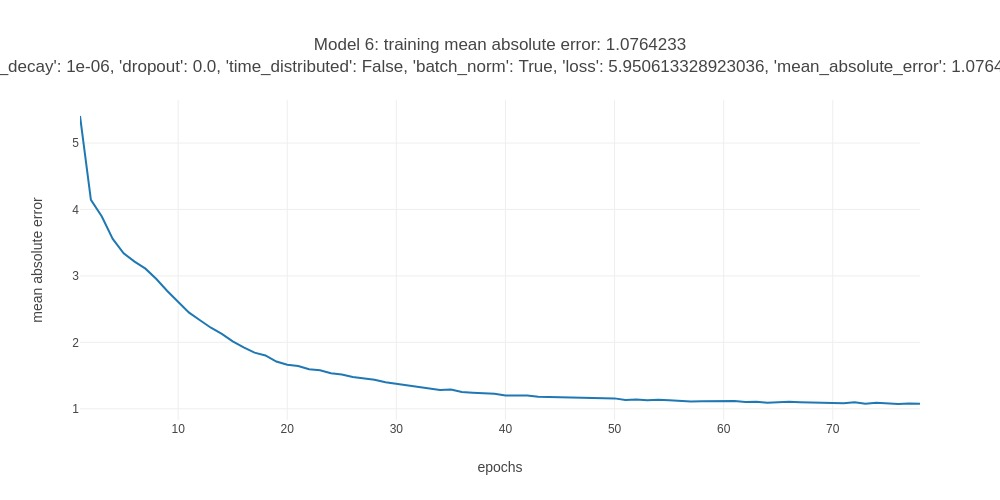

18-19-05 | INFO | models/model-6/20190603181905
INFO:CS230:models/model-6/20190603181905
18-19-05 | INFO | {'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}
INFO:CS230:{'seq_len': 10, 'cols_x': 'x1', 'cols_y': 'y1', 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'dropout': 0.1, 'time_distributed': True, 'batch_norm': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 10, 27)            5940      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 27)            756       
_________________________________________________________________
lstm_79 (LSTM)               (None, 27)                5940      
_________________________________________________________________
dense_60 (Dense)             (None, 21)                588       
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


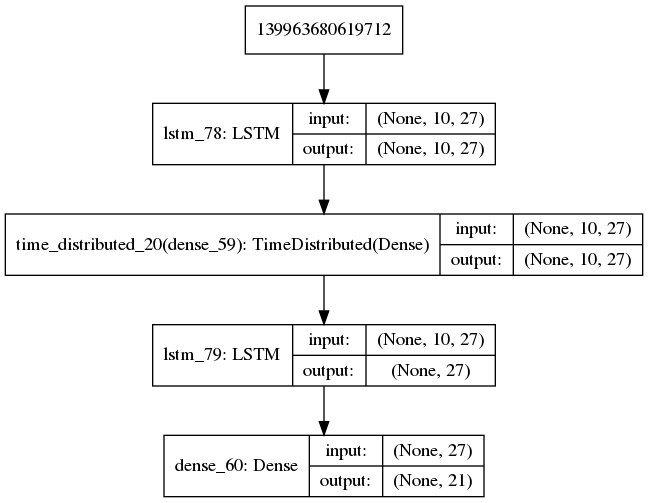

Epoch 1/200
1001/1002 [============================>.] - ETA: 0s - loss: 325.1024 - mean_absolute_error: 5.3678
Epoch 00001: loss improved from inf to 324.95983, saving model to models/model-6/20190603181905/epoch1.h5
1002/1002 [==============================] - 28s 28ms/step - loss: 324.7811 - mean_absolute_error: 5.3636
Epoch 2/200
 999/1002 [============================>.] - ETA: 0s - loss: 274.0935 - mean_absolute_error: 4.1888
Epoch 00002: loss improved from 324.95983 to 274.70904, saving model to models/model-6/20190603181905/epoch2.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 274.5559 - mean_absolute_error: 4.1957
Epoch 3/200
1001/1002 [============================>.] - ETA: 0s - loss: 241.0532 - mean_absolute_error: 4.0030
Epoch 00003: loss improved from 274.70904 to 241.73862, saving model to models/model-6/20190603181905/epoch3.h5
1002/1002 [==============================] - 21s 21ms/step - loss: 241.6047 - mean_absolute_error: 4.0072
Epoch 4/200
1001

KeyboardInterrupt: 

In [12]:
DATA = None
best_params = {
    'mean_absolute_error': 1000,
}
if os.path.exists(RESULTS_FILE_PATH):
    df_results = pandas.read_csv(RESULTS_FILE_PATH)
else:
    df_results = pandas.DataFrame()

best_params_path = os.path.join(MODEL_DIR, 'best_params.json')
with open(best_params_path, 'r') as f:
    best_params = json.load(f)

for sequence_length in range(10, 100, 10):
    for cols_x in ['x1', 'x2']:
        for cols_y in ['y1', 'y2']:
            
            del DATA
            DATA = get_data(cols_x, cols_y, sequence_length)
            
            for learning_rate in [1e-3]:
                for learning_rate_decay in [0, 1e-6]:
                    for dropout in [0, 0.1]:
                        for time_distributed in [True, False]:
                            for batch_norm in [False, True]:
                                try:
                                    dt_start = datetime.datetime.now()

                                    SESS_DATE_TIME = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
                                    SESS_DIR = os.path.join(MODEL_DIR, SESS_DATE_TIME)
                                    params = {
                                        'seq_len': int(sequence_length),
                                        'cols_x': cols_x,
                                        'cols_y': cols_y,
                                        'learning_rate': float(learning_rate),
                                        'learning_rate_decay': float(learning_rate_decay),
                                        'dropout': float(dropout),
                                        'time_distributed': time_distributed,
                                        'batch_norm': batch_norm,
                                    }

                                    # check if already tried these params
                                    isin_map = {}
                                    keys = []
                                    for key, val in six.iteritems(params):
                                        isin_map[key] = [val]
                                        keys.append(key)

                                    if not df_results.empty and (True in df_results[keys].isin(isin_map).all(axis=1).values):
                                        logging.warning('skipping, already in results: %s', params)
                                        continue

                                    for dir_path in [MODEL_DIR, SESS_DIR]:
                                        if not os.path.isdir(dir_path):
                                            os.mkdir(dir_path)
                                    with open(os.path.join(SESS_DIR, 'params.json'), 'w') as f:
                                        json.dump(params, f)

                                    logger.info(SESS_DIR)
                                    logger.info(params)
                                    slack_post(text='`%s` params : %s' % (SESS_DIR, params))

                                    m = DATA[data_name]['df']['x'].shape[0]
                                    n_x = DATA[data_name]['df']['x'].shape[1]
                                    n_y = DATA[data_name]['df']['y'].shape[1]

                                    # build model
                                    model = tf.keras.Sequential()

                                    model.add(tf.keras.layers.LSTM(n_x, return_sequences=True, dropout=dropout, 
                                                                   recurrent_dropout=dropout, 
                                                                   input_shape=(sequence_length, n_x)))

                                    if batch_norm:
                                        model.add(tf.keras.layers.BatchNormalization())

                                    if time_distributed:
                                        model.add(tf.keras.layers.TimeDistributed(
                                            tf.keras.layers.Dense(n_x, activation='sigmoid')))

                                    model.add(tf.keras.layers.LSTM(n_x, dropout=dropout, 
                                                                   recurrent_dropout=dropout))

                                    #model.add(tf.keras.layers.BatchNormalization())
                                    #model.add(tf.keras.layers.Dropout(0.1))
                                    model.add(tf.keras.layers.Dense(n_y, activation='linear'))
                                    # TODO sigmoid with multiplier for range
                                    # TODO reduce to 1 output at a time to fully understand

                                    # summarize model
                                    model.summary()

                                    # visualize model
                                    file_path = os.path.join(SESS_DIR, 'architecture.png')
                                    tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
                                    display(Image(filename=file_path))

                                    # set optimizer
                                    #optimizer = tf.train.AdamOptimizer(0.01)
                                    optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=learning_rate_decay)
                                    #optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

                                    # compile model
                                    model.compile(
                                        optimizer=optimizer, 
                                        loss='mean_squared_error', 
                                        metrics=['mean_absolute_error']
                                    )

                                    # set callbacks
                                    file_path = os.path.join(SESS_DIR, 'epoch{epoch}.h5')
                                    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='loss', 
                                                        verbose=1, save_weights_only=True, save_best_only=True, mode='min')
                                    stop_callback = tf.keras.callbacks.EarlyStopping(
                                                        monitor='loss', min_delta=1e-2, patience=5, verbose=1)
                                    callbacks = [checkpoint_callback, stop_callback]

                                    # train model
                                    history = model.fit_generator(
                                        DATA['train']['generator'], 
                                        epochs=EPOCHS, 
                                        steps_per_epoch=len(DATA['train']['generator']), 
                                        callbacks=callbacks
                                    )

                                    # save model
                                    file_name = 'model_end_%s.h5' % history.history['mean_absolute_error'][-1]
                                    model.save(os.path.join(SESS_DIR, file_name))

                                    # save time
                                    dt_delta = datetime.datetime.now() - dt_start
                                    total_time = '%s:%s' % (int(dt_delta.total_seconds() / 60), round(dt_delta.total_seconds() % 60))

                                    # save results 
                                    params['loss'] = float(history.history['loss'][-1])
                                    params['mean_absolute_error'] = float(history.history['mean_absolute_error'][-1])
                                    params['session'] = SESS_DIR
                                    params['time'] = total_time
                                    if df_results.empty:
                                        df_results = pandas.DataFrame([params])
                                    else:
                                        df_results = pandas.concat([df_results, pandas.DataFrame([params])], 
                                                                   ignore_index=True, sort=False)
                                    df_results.to_csv(RESULTS_FILE_PATH)

                                    # post result to slack
                                    slack_post(text='`%s` time : `%s`, error : *%s*, loss: *%s*' % (SESS_DIR, total_time,
                                           history.history['mean_absolute_error'][-1], history.history['loss'][-1]))

                                    # save best params
                                    if history.history['mean_absolute_error'][-1] < best_params['mean_absolute_error']:
                                        best_params = copy.deepcopy(params)

                                        slack_post(text='`%s` :bananadance: best' % (SESS_DIR))

                                        with open(best_params_path, 'w') as f:
                                            json.dump(best_params, f)

                                    # plot error
                                    file_path = os.path.join(SESS_DIR, 'training_error.jpeg')
                                    title = 'Model 6: training mean absolute error: %s<br>%s' % (
                                        history.history['mean_absolute_error'][-1],
                                        params
                                    )
                                    trace = plotly.graph_objs.Scatter(
                                        x=list(range(1, len(pandas.DataFrame(history.history['mean_absolute_error']))+1)),
                                        y=history.history['mean_absolute_error']
                                    )
                                    layout = plotly.graph_objs.Layout(
                                        title=title,
                                        xaxis=dict(title='epochs'),
                                        yaxis=dict(title='mean absolute error')
                                    )
                                    fig = plotly.graph_objs.Figure(data=[trace], layout=layout)

                                    # save plot to file
                                    plotly.io.write_image(fig, file_path, width=1000, height=500)

                                    # display plot from file
                                    display(Image(filename=file_path))

                                    logging.info('best params: %s', best_params)

                                except Exception as e:
                                    logger.exception(e)
                                    slack_post(text=':facepalm: `%s`' % str(e))

                                del model
                                del params
                                del history